# PART 4: PRE-PROCESSING

## Import Statements

In [1]:
import os, sys
sys.path.append(os.path.abspath('..'))

from octcv.arrViz import *

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

In [3]:
from warnings import filterwarnings
filterwarnings(action='ignore')

## Loading Metadata Table 

In [4]:
metadata = pd.read_csv('../datasrc/compositeOCT_metadata.csv')
print(metadata.shape);metadata.head()

(1280, 6)


dx_class patient_id laterality image_type  set  \
0  glaucoma     001978         OS     volume    1   
1    normal     002743         OS     volume    1   
2  glaucoma     001086         OS     volume    1   
3  glaucoma     000092         OS     volume    1   
4  glaucoma     003223         OD     volume    1   

                                            filepath  
0  ../datasrc/volumesOCT/POAG-001978-2012-02-08-O...  
1  ../datasrc/volumesOCT/Normal-002743-2009-03-26...  
2  ../datasrc/volumesOCT/POAG-001086-2008-08-04-O...  
3  ../datasrc/volumesOCT/POAG-000092-2010-12-14-O...  
4  ../datasrc/volumesOCT/POAG-003223-2014-01-10-O...

## Dummy/Indicator Features for Categorical Variables 

Although some ML classification frameworks might be more flexible with the data types of features, will convert the columns potentially relevant to classification just in case.

### Target Variable: `dx_class` --> `glaucoma`

In [5]:
ntarg = 'glaucoma'
otarg = 'dx_class'
oldcols = list(metadata.columns)

if ntarg not in list(metadata.columns):
    newcolmap = {otarg:ntarg} # Save mapping for future reference
    new_target = pd.get_dummies(metadata[otarg], dtype='int')[ntarg] # Series for the new numerical column
    loc = metadata.columns.get_loc(otarg) + 1 # Add 1 to place it after the original target
    metadata.insert(loc,ntarg,new_target) # Insert the series after after `dx_class` as `glaucoma` column
    
print(newcolmap,'\n')
print(metadata.dtypes,'\n')
metadata.head()

{'dx_class': 'glaucoma'} 

dx_class      object
glaucoma       int64
patient_id    object
laterality    object
image_type    object
set            int64
filepath      object
dtype: object 



dx_class  glaucoma patient_id laterality image_type  set  \
0  glaucoma         1     001978         OS     volume    1   
1    normal         0     002743         OS     volume    1   
2  glaucoma         1     001086         OS     volume    1   
3  glaucoma         1     000092         OS     volume    1   
4  glaucoma         1     003223         OD     volume    1   

                                            filepath  
0  ../datasrc/volumesOCT/POAG-001978-2012-02-08-O...  
1  ../datasrc/volumesOCT/Normal-002743-2009-03-26...  
2  ../datasrc/volumesOCT/POAG-001086-2008-08-04-O...  
3  ../datasrc/volumesOCT/POAG-000092-2010-12-14-O...  
4  ../datasrc/volumesOCT/POAG-003223-2014-01-10-O...

### Laterality: `laterality`

In [6]:
l_eye = 'left_eye'
lat = 'laterality'

if l_eye not in list(metadata.columns):
    newcolmap[lat]=l_eye
    leyeSer = pd.get_dummies(metadata.laterality,dtype='int',drop_first=True)
    loc = metadata.columns.get_loc(lat) + 1
    metadata.insert(loc,l_eye,leyeSer)

print(newcolmap,'\n')
print(metadata.dtypes,'\n')
metadata.head()

{'dx_class': 'glaucoma', 'laterality': 'left_eye'} 

dx_class      object
glaucoma       int64
patient_id    object
laterality    object
left_eye       int64
image_type    object
set            int64
filepath      object
dtype: object 



dx_class  glaucoma patient_id laterality  left_eye image_type  set  \
0  glaucoma         1     001978         OS         1     volume    1   
1    normal         0     002743         OS         1     volume    1   
2  glaucoma         1     001086         OS         1     volume    1   
3  glaucoma         1     000092         OS         1     volume    1   
4  glaucoma         1     003223         OD         0     volume    1   

                                            filepath  
0  ../datasrc/volumesOCT/POAG-001978-2012-02-08-O...  
1  ../datasrc/volumesOCT/Normal-002743-2009-03-26...  
2  ../datasrc/volumesOCT/POAG-001086-2008-08-04-O...  
3  ../datasrc/volumesOCT/POAG-000092-2010-12-14-O...  
4  ../datasrc/volumesOCT/POAG-003223-2014-01-10-O...

### Patient: `patient_id` - residual cleaning

#### Attempt `object` --> `int` 

In [7]:
N_patients = len(metadata.patient_id.unique()); print(f"Number of Patients: {N_patients}")

Number of Patients: 650


In [8]:
# Preview N_patients if patient_id converted to int
len(metadata.patient_id\
    .str.replace('P_','')\
    .astype('int')\
    .sort_values().unique())

647

The loss of three suggests some overlap in numbering.

#### Splitting & Rejoining Original Sets for Proxy Patient ID Numbers

In [9]:
# Split into original sets
idf = metadata[metadata.set == 2]
vdf = metadata[metadata.set == 1]

# Create new column for patient_id's converted to integers (pid_int) for both dataframes
pidint = 'pid_int'
opid = 'patient_id'

if pidint not in list(metadata.columns):
    # Append to newcolmap for later reference
    newcolmap[opid] = pidint

    # Convert patient_id's to integers in the new column (pid_int)
    vdf[pidint] = vdf[opid].astype('int')
    idf[pidint] = idf[opid].str.replace('P_','').astype('int') + 4000

    # Re-join / concatenate
    metadata = pd.concat([vdf,idf],axis=0)

    # Re-order columns so that pid_int is next to patient_id
    loc = metadata.columns.get_loc(opid) + 1
    pidintSer = metadata.pop(pidint)
    metadata.insert(loc,pidint,pidintSer)

    # Sort by pid_int (i.e., numerical sort of patient_id "by proxy")
    metadata = metadata.sort_values(pidint)
    
print(newcolmap,'\n')
print(metadata.dtypes,'\n')
metadata.head()

{'dx_class': 'glaucoma', 'laterality': 'left_eye', 'patient_id': 'pid_int'} 

dx_class      object
glaucoma       int64
patient_id    object
pid_int        int64
laterality    object
left_eye       int64
image_type    object
set            int64
filepath      object
dtype: object 



dx_class  glaucoma patient_id  pid_int laterality  left_eye image_type  \
826    normal         0     000002        2         OD         0     volume   
813    normal         0     000002        2         OS         1     volume   
53   glaucoma         1     000008        8         OD         0     volume   
426  glaucoma         1     000014       14         OD         0     volume   
747  glaucoma         1     000014       14         OS         1     volume   

     set                                           filepath  
826    1  ../datasrc/volumesOCT/Normal-000002-2009-10-28...  
813    1  ../datasrc/volumesOCT/Normal-000002-2009-10-28...  
53     1  ../datasrc/volumesOCT/POAG-000008-2009-02-03-O...  
426    1  ../datasrc/volumesOCT/POAG-000014-2009-11-30-O...  
747    1  ../datasrc/volumesOCT/POAG-000014-2009-11-30-O...

#### Re-map ordered `patient_id`'s to proxy identification (`PIN`)

As the `patient_id` column reflects the original identification used in the respective research studies, there are some missing numbers (e.g., maybe representing patients later excluded from their study).  For our sake, we can keep this in order to trace it back to the original datasets/studies if needed later on, but create a new column for our own proxy identification -- we can call this `PIN` for "Patient Identification Number":

In [10]:
# Double check that the number of patients matches the original
uniq_pidints = metadata.pid_int.unique()
N_patients == len(uniq_pidints)

True

In [11]:
# Dictionary comprehension to map the pid_int to a more simple ordinal numbering (basically from 1 to N_patients)
pid2pin = {pid:f"{i+1:03d}" for i,pid in enumerate(uniq_pidints)}

# Create new column PIN using mapping of pid_int to proxy identification (1 to N_patients)
pin = 'PIN'
if pin not in list(metadata.columns):
    # Append newcolmap for future reference
    newcolmap['patient_id']=pin
    pinSer = metadata[pidint].apply(lambda p : pid2pin[p]) # re-map pidint to create new 'PIN' series

    # Replace pid_int with the re-mapped 'PIN' series 
    loc = metadata.columns.get_loc(pidint) # get column index of pid_int
    metadata = metadata.drop(pidint,axis=1) # drop pid_int (going to replace it)
    metadata.insert(loc,pin,pinSer) # place re-mapped series at the original location of pid_int, and name it 'PIN'

print(newcolmap,'\n')
print(metadata.dtypes,'\n')
metadata.head()

{'dx_class': 'glaucoma', 'laterality': 'left_eye', 'patient_id': 'PIN'} 

dx_class      object
glaucoma       int64
patient_id    object
PIN           object
laterality    object
left_eye       int64
image_type    object
set            int64
filepath      object
dtype: object 



dx_class  glaucoma patient_id  PIN laterality  left_eye image_type  set  \
826    normal         0     000002  001         OD         0     volume    1   
813    normal         0     000002  001         OS         1     volume    1   
53   glaucoma         1     000008  002         OD         0     volume    1   
426  glaucoma         1     000014  003         OD         0     volume    1   
747  glaucoma         1     000014  003         OS         1     volume    1   

                                              filepath  
826  ../datasrc/volumesOCT/Normal-000002-2009-10-28...  
813  ../datasrc/volumesOCT/Normal-000002-2009-10-28...  
53   ../datasrc/volumesOCT/POAG-000008-2009-02-03-O...  
426  ../datasrc/volumesOCT/POAG-000014-2009-11-30-O...  
747  ../datasrc/volumesOCT/POAG-000014-2009-11-30-O...

Will leave `image_type` and `filepath` alone for now, as they are subject to changes in subsequent sections of this notebook. 

For now will keep `metadata` DataFrame as is with both the original columns and the encoded/proxy ones, and then later drop the original columns as needed for modeling (i.e., to prepare an entirely numeric DataFrame that can be converted to an array, but still being able to convert back to categorical labels for human interpretation later on).

## Volume/Image Array Standardization 

### Reconfiguring SET 2 Metadata 

#### Subsetting into original sets again

In [12]:
# Subset dataframes for each set again
vMeta = metadata[metadata.set == 1]
iMeta = metadata[metadata.set == 2]

# Preview Shapes
print(vMeta.shape,iMeta.shape)

(1110, 9) (170, 9)


In [13]:
iMeta.head()

dx_class  glaucoma patient_id  PIN laterality  left_eye image_type  set  \
1233    normal         0        P_1  625         OS         1       disc    2   
1126  glaucoma         1        P_1  625         OS         1     b-scan    2   
1232    normal         0        P_1  625         OS         1        cup    2   
1231    normal         0        P_1  625         OD         0        cup    2   
1230    normal         0        P_1  625         OD         0     b-scan    2   

                                               filepath  
1233  ../datasrc/fundus-oct-composite/Healthy/P_1/Le...  
1126  ../datasrc/fundus-oct-composite/Glaucoma/P_1/L...  
1232  ../datasrc/fundus-oct-composite/Healthy/P_1/Le...  
1231  ../datasrc/fundus-oct-composite/Healthy/P_1/Ri...  
1230  ../datasrc/fundus-oct-composite/Healthy/P_1/Ri...

#### Patient-Centered Subsetting

To subset and view all images for a given patient, the hierarchy to follow should be:

+ `PIN`
    + `glaucoma` - `left_eye` Pairs
        + `image_type` --> `filepath`
     
That is, for given patient (`PIN`), first subset all rows containing that `PIN`.  Then, for each unique scan (`glaucoma`-`left_eye` pair), you can extract the associated `dx_class`-`laterality` pair for figure labeling, and then get the three different images for each scan (`filepath` with `image_type`).

In [14]:
def getPtDataFrame(pin,df=iMeta):
    # Subset "patient dataframe" for the provided PIN: ptdf
    pin = str(pin)
    sort_cols = ['dx_class','laterality','image_type','filepath']
    ptdf = df[df.PIN == pin].sort_values(sort_cols)
    return ptdf

In [15]:
def figAsMainTitle(title_input,pin_wrap=False,figsize=(8.09,0.01),
                   bbox_color='yellow',bbox_alpha=0.5):
    # Format main_title from title
    title_input=str(title_input)
    if pin_wrap:
        main_title = f"Patient #{title_input} (PIN)"
    else:
        main_title = title_input
        
    # Use a subplot as a main title block, within rc_context to whiteout the grid/axes/tickmarks,etc.
    with plt.rc_context({'axes.edgecolor': 
                         'white', 'xtick.color': 'white', 
                         'ytick.color': 'white'}):    
        title_fig,_ = plt.subplots(1,1,figsize=figsize)
        title_fig.suptitle(main_title,fontsize=18, 
                           bbox=dict(facecolor=bbox_color,
                                     alpha=bbox_alpha))
        return title_fig

In [16]:
# Plot a different figure for each pairing of `glaucoma` and `left_eye`
def plotImagesByPIN(pin,df=iMeta,
                    title_figsize = (8.09,0.01),
                    title_bbox_color='yellow', 
                    title_bbox_alpha=0.5,
                    subplot_figsize = (8,2), 
                    suptitle_bbox_color='lightblue',
                    suptitle_bbox_alpha=0.5,
                    rescale=.2):
    
    # Get Patient DataFrame
    ptdf = getPtDataFrame(pin=pin,df=df)

    # Use a subplot as a main title block, within rc_context to whiteout the grid/axes/tickmarks,etc.
    title_fig = figAsMainTitle(title_input=pin, pin_wrap=True, figsize=title_figsize)
        
    # Define all possible pairings of `glaucoma` and `left_eye`
    glaucLEpairs= [ (i,j) for i in range(2) for j in range(2) ]
    
    # Iterate through possible pairs
    for pair in glaucLEpairs:
        # Subset the rows of ptdf that have the same paring
        g,l = pair
        matched_rows = ptdf[ptdf.glaucoma == g][ptdf.left_eye == l]
        
        # Get number of matches
        n = len(matched_rows)

        # Plot all images for a given pairing as subplots of the same figure unless there are none
        if n > 0:
            pairs_str = (matched_rows.iloc[0].dx_class, matched_rows.iloc[0].laterality)
            fig,ax = plt.subplots(1,n,figsize=subplot_figsize)

            axf = ax.flat if n > 1 else ax

            # Use the original string versions of the two features for the title of the whole figure for a given pairing
            suptitle = pairs_str[0].capitalize() + ', ' + pairs_str[1]
            
            fig.suptitle(suptitle, fontweight = 'bold', 
                         horizontalalignment = 'left', x=0.1,
                         bbox=dict(facecolor = suptitle_bbox_color, 
                                   alpha = suptitle_bbox_alpha)
                        )

            # Plot all images that match the pairing
            for i in range(n):
                axis = axf[i] if n > 1 else axf
                
                # Load arrays from filepaths
                fp = matched_rows.iloc[i].filepath 
                arr = vizInputParser(fp)

                # Rescale for lightweight display per provided factor 0-1
                if isinstance(rescale,float):
                    if rescale < 1 and rescale > 0:
                        arr = cv2.resize(arr,dsize=None,
                                         fx=rescale,fy=rescale, 
                                         interpolation=cv2.INTER_AREA)
                    else:
                        raise ValueError('Argument for `rescale=` must be a float between 0 and 1')
                else:
                    raise ValueError('Argument for `rescale=` must be a float between 0 and 1')  

                # Display in subplot
                axis.imshow(arr)

                # Get the `image_type` to use for subplot title
                imgtype = matched_rows.iloc[i].image_type
                axis.set_title(imgtype)


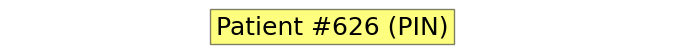

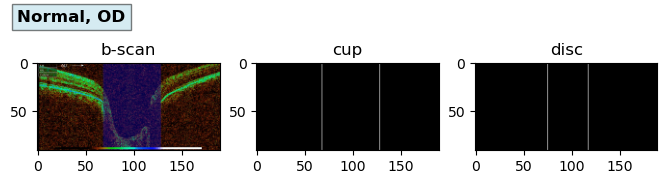

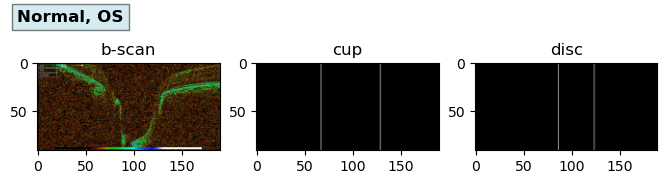

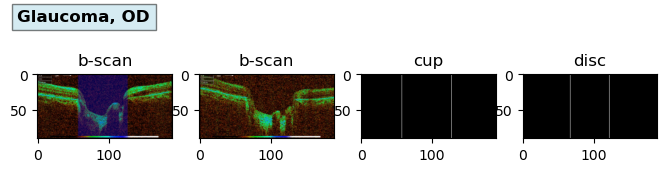

In [17]:
plotImagesByPIN(626)

Of note, there are sometimes two b-scan images of the same eye and same diagnostic class, although one is shaded and one is not.  Nevertheless, it would seem while they are technically different images and not duplicates, the cup boundaries in the mask image appears to apply to both (i.e., both b-scan images are quite closely aligned.

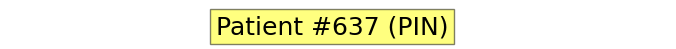

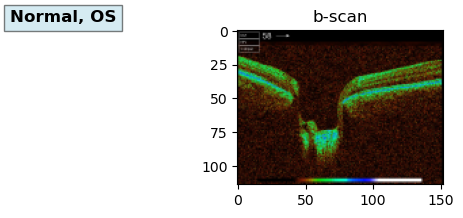

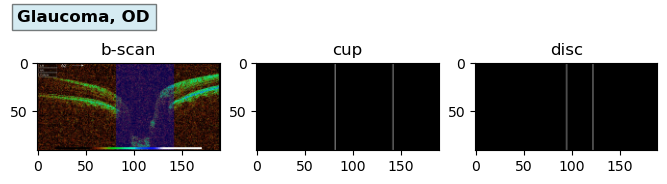

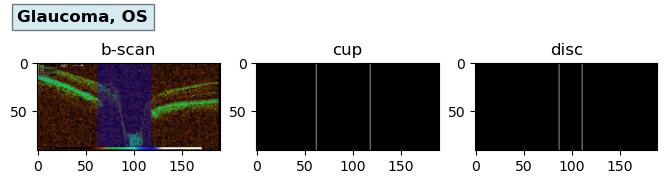

In [18]:
plotImagesByPIN(637)

For patient #637, the Normal, OS scan does not have accompanying mask images nor is the cup region shaded in - thus images like these will likely need to be dropped from the dataset.<sup>&dagger;</sup>  

Meanwhile the Glaucoma,OD / Glaucoma,OS ones have both shading and mask images, so will keep ones like these.

<sup>&dagger;</sup> <i>May consider for a future project: training segmentation models to automatically identify such boundaries using the existing labeled sets or potentially labelling by subject-matter experts for additional data points.</i>

#### Making Rows of SET 2 Metadata Correspond to B-scans and their corresponding masks

Since there are multiple images per patient, some of which may be masks/boundary lines instead of actual scans, it will be helpful to be able to access whole sets of image files for any given patient in order to make use of the masks on their associated b-scan image.

In [19]:
# Convert iMeta to pivot table ipt ("image pivot table") 
    # such that each row is a specific b-scan image 
    # (i.e., b-scan, cup, disc for a given scan all in a single row)

ipt =iMeta.pivot_table(
                        index=['dx_class','glaucoma','PIN','laterality','left_eye'],
                        columns='image_type', 
                        values='filepath',
                        aggfunc='first'
                        ).reset_index()
ipt.head()

image_type  dx_class  glaucoma  PIN laterality  left_eye  \
0           glaucoma         1  625         OS         1   
1           glaucoma         1  626         OD         0   
2           glaucoma         1  627         OD         0   
3           glaucoma         1  627         OS         1   
4           glaucoma         1  628         OD         0   

image_type                                             b-scan  \
0           ../datasrc/fundus-oct-composite/Glaucoma/P_1/L...   
1           ../datasrc/fundus-oct-composite/Glaucoma/P_2/R...   
2           ../datasrc/fundus-oct-composite/Glaucoma/P_3/R...   
3           ../datasrc/fundus-oct-composite/Glaucoma/P_3/L...   
4           ../datasrc/fundus-oct-composite/Glaucoma/P_4/R...   

image_type                                                cup  \
0           ../datasrc/fundus-oct-composite/Glaucoma/P_1/L...   
1           ../datasrc/fundus-oct-composite/Glaucoma/P_2/R...   
2           ../datasrc/fundus-oct-composite/Glaucoma/P_3/R...   
3           ../datasrc/fundus-oct-composite/Glaucoma/P_3/L...   
4           ../datasrc/fundus-oct-composite/Glaucoma/P_4/R...   

image_type                                               disc  
0           ../datasrc/fundus-oct-composite/Glaucoma/P_1/L...  
1           ../datasrc/fundus-oct-composite/Glaucoma/P_2/R...  
2           ../datasrc/fundus-oct-composite/Glaucoma/P_3/R...  
3           ../datasrc/fundus-oct-composite/Glaucoma/P_3/L...  
4           ../datasrc/fundus-oct-composite/Glaucoma/P_4/R...

In [20]:
# Reformat for better clarity
ipt.columns.name = None # Remove the `image_type` name (the umbrella category for b-scan, cup, disc)
ipt.columns = ipt.columns.str.replace('-','')  # Remove dash from b-scan to make it easier to access

# Add _path suffix to all the columns for filepaths
old_fpcols = "bscan cup disc".split(' ') 
new_fpcols = [ c + "_path" for c in old_fpcols ]
ipt = ipt.rename(columns={old:new for old,new in zip(old_fpcols,new_fpcols)})

# Preview
print(ipt.info()); ipt.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   dx_class    79 non-null     object
 1   glaucoma    79 non-null     int64 
 2   PIN         79 non-null     object
 3   laterality  79 non-null     object
 4   left_eye    79 non-null     int64 
 5   bscan_path  79 non-null     object
 6   cup_path    45 non-null     object
 7   disc_path   45 non-null     object
dtypes: int64(2), object(6)
memory usage: 5.1+ KB
None


dx_class  glaucoma  PIN laterality  left_eye  \
0  glaucoma         1  625         OS         1   
1  glaucoma         1  626         OD         0   
2  glaucoma         1  627         OD         0   
3  glaucoma         1  627         OS         1   
4  glaucoma         1  628         OD         0   

                                          bscan_path  \
0  ../datasrc/fundus-oct-composite/Glaucoma/P_1/L...   
1  ../datasrc/fundus-oct-composite/Glaucoma/P_2/R...   
2  ../datasrc/fundus-oct-composite/Glaucoma/P_3/R...   
3  ../datasrc/fundus-oct-composite/Glaucoma/P_3/L...   
4  ../datasrc/fundus-oct-composite/Glaucoma/P_4/R...   

                                            cup_path  \
0  ../datasrc/fundus-oct-composite/Glaucoma/P_1/L...   
1  ../datasrc/fundus-oct-composite/Glaucoma/P_2/R...   
2  ../datasrc/fundus-oct-composite/Glaucoma/P_3/R...   
3  ../datasrc/fundus-oct-composite/Glaucoma/P_3/L...   
4  ../datasrc/fundus-oct-composite/Glaucoma/P_4/R...   

                                           disc_path  
0  ../datasrc/fundus-oct-composite/Glaucoma/P_1/L...  
1  ../datasrc/fundus-oct-composite/Glaucoma/P_2/R...  
2  ../datasrc/fundus-oct-composite/Glaucoma/P_3/R...  
3  ../datasrc/fundus-oct-composite/Glaucoma/P_3/L...  
4  ../datasrc/fundus-oct-composite/Glaucoma/P_4/R...

##### Dividing Scan-Centered Pivot Table based on Availability of Mask Images

As seen with `ipt.info()`, it would seem that there is an equal number of "cup" images missing as there are "disc" images missing.  Nevertheless, there may still be a reasonable way to crop B-scans that lack such mask images (i.e., some of them may still have regions shaded in directly).  But to accomodate different methods of cropping, I will split up `ipt` into those with and without mask images (`bwm` for "b-scans with masks" and `bOnly` for "only b-scans"/no masks):

In [21]:
# Subset only b-scans that have masks (bwm for b-scan with masks)
bwm = ipt[~ipt.cup_path.isnull()]

# Subset only b-scans that don't have masks, dropping cup & disc columns 
bOnly = ipt[ipt.cup_path.isnull()].drop(columns=['cup_path', 'disc_path'])

# Check summaries of each
print(bwm.info())
print('\n')
print(bOnly.info())
print('\n')

<class 'pandas.core.frame.DataFrame'>
Index: 45 entries, 0 to 68
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   dx_class    45 non-null     object
 1   glaucoma    45 non-null     int64 
 2   PIN         45 non-null     object
 3   laterality  45 non-null     object
 4   left_eye    45 non-null     int64 
 5   bscan_path  45 non-null     object
 6   cup_path    45 non-null     object
 7   disc_path   45 non-null     object
dtypes: int64(2), object(6)
memory usage: 3.2+ KB
None


<class 'pandas.core.frame.DataFrame'>
Index: 34 entries, 25 to 78
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   dx_class    34 non-null     object
 1   glaucoma    34 non-null     int64 
 2   PIN         34 non-null     object
 3   laterality  34 non-null     object
 4   left_eye    34 non-null     int64 
 5   bscan_path  34 non-null     object
dtypes: int64(2), object(4)


The above `bOnly` images will need to be parsed by their colors to determine if there is a shaded region and otherwise drop the "uncroppable" ones (i.e., neither shaded region nor accompanying mask image).

For now, will start first with cropping `bwm` images using their masks - as seen in the visualizations earlier, it would seem that the `cup` boundaries better match the shaded regions in patient sets where such are both available, and additionally encompass a wider region of the image than the `disk` boundaries - thus, we will use `cup` images while leaving the option to crop down further using the `disk` images if necessary.

### Aspect Ratio 

Regardless of what slice index we choose for extracting slices from the volumes, the dimensions of the slice will always be 64px by128px (width by height) - aspect ratio of 1:2.  <br>

**Objective**<br>
So the goal is to crop the 2D images down such that the resulting image has a similar if not identical aspact ratio.  Hopefully, if similar enough, then some re-scaling can get it to exactly 1:2 in later steps without altering the key features of the image / significantly affecting how the CNN interprets them.

The proper aggregates of images with labels correctly matches `PIN`, `glaucoma`, and `left_eye` columns.

In [22]:
bwm.groupby(['PIN','glaucoma','left_eye']).count()[['bscan_path', 'cup_path', 'disc_path']].T

PIN        625       626       627           ... 634 635       636    637     \
glaucoma     0     1   0     1   0     1     ...   1   0  1      1      1      
left_eye     0  1  1   0  1  0   0  1  0  1  ...   1   0  0  1   0  1   0  1   
bscan_path   1  1  1   1  1  1   1  1  1  1  ...   1   1  1  1   1  1   1  1   
cup_path     1  1  1   1  1  1   1  1  1  1  ...   1   1  1  1   1  1   1  1   
disc_path    1  1  1   1  1  1   1  1  1  1  ...   1   1  1  1   1  1   1  1   

PIN        638     
glaucoma     1     
left_eye     0  1  
bscan_path   1  1  
cup_path     1  1  
disc_path    1  1  

[3 rows x 45 columns]

#### Cropping Images WITH Masks (`bwm`)

##### Cropping an Example Image

###### Horizontal Cropping to Optic Cup Region

Using the associated `cup`/`disc` images, we can determine the horizontal coordinates outside of which we can crop out.  Per the exploration earlier, it would seem that `cup` is a good one to start with and will preserve more of the image (i.e., can crop further later on if needed).  

In [23]:
scan = bwm.iloc[0]
cup = vizInputParser(scan['cup_path'])
disc = vizInputParser(scan['disc_path'])
bscan = vizInputParser(scan['bscan_path'])

(456, 326, 3) 1.3987730061349692


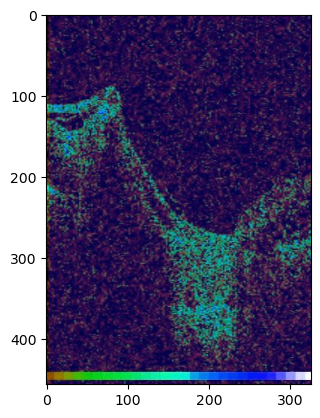

In [24]:
mask_non_black = np.any(cup != np.array([0, 0, 0]), axis=-1)  # True where pixel != black

# Get unique column indices of white pixels in the mask image (cup in this case)
cols_with_non_black = np.unique(np.where(mask_non_black)[1])

# Get the outermost columns
xmin, xmax = cols_with_non_black[0], cols_with_non_black[-1]

# Crop the B-scan image using the outermost columns of white pixels in the mask image
bscan_cropped = bscan[:, xmin:xmax]


plt.imshow(bscan_cropped)
shape = bscan_cropped.shape
ar = bscan_cropped.shape[0] / bscan_cropped.shape[1]
print(shape, ar)

Of note, there still remains the horizontal color bar at the bottom of the image that may detract from the actual visual features of the image.

As the color transition / intensity transition seems fairly stark between the actual image and the horizontal color bar, we may be able to make use of that in order to automate cropping.

###### Vertical Cropping to Remove Horizontal Color Scale Bar

**Calculating average degree of color transition along the Y-axis (`axis=0`)**

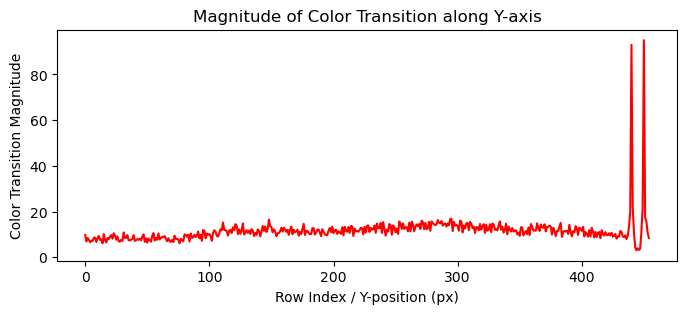

In [25]:
# Re-assign the "cropped" image to bscanSC for "bscan side-cropped" as cropping is not actually finished 
bscanSC = bscan_cropped

# Convert values to regular int instead of uint8 
bscanSC = bscanSC.astype(int)

# Calculate "running difference" between all values along axis 0 (delta of array value over delta of y/row index)
dVdY = np.diff(bscanSC,axis=0)

# Convert to magnitudes
mag_dVdY = np.abs(dVdY)

# Average across all columns (axis=1) and color channels (axis=2)
# resulting in a linear array of scores for each row transition
row_scores = mag_dVdY.mean(axis=(1,2))

# Plot row scores
_ = plt.figure(figsize=(8,3))
plt.title('Magnitude of Color Transition along Y-axis')
plt.xlabel('Row Index / Y-position (px)')
plt.ylabel('Color Transition Magnitude')
_ = plt.plot(np.arange(len(row_scores)),row_scores,c='r')

So there are some very stark transitions around where we see the color bars in the actual image earlier.  We can likely apply a threshold for a magnitude of > 30 to isolate the rows right before the transition to the color bars.

**Getting row index of the first peak / top of the color scale bar**

In [26]:
# Get indices of the two peaks seen earlier using a threshold of 30
threshold = 30
peak_indices = np.where(row_scores > threshold)[0]
peak_indices

array([440, 450])

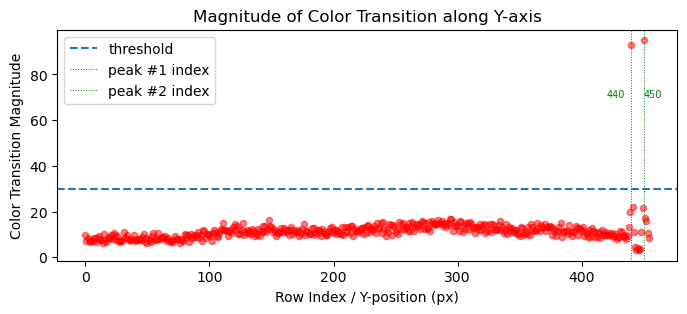

In [27]:
_ = plt.figure(figsize=(8,3))
plt.title('Magnitude of Color Transition along Y-axis')
plt.xlabel('Row Index / Y-position (px)')
plt.ylabel('Color Transition Magnitude')


_ = plt.scatter(np.arange(len(row_scores)),row_scores,c='r', s=20, alpha=0.5)

plt.axhline(threshold,ls='--',label='threshold')
for i,pi in enumerate(peak_indices):
    plt.axvline(pi, c='g', lw=.7,ls=':', label=f'peak #{i+1} index')
    plt.annotate(pi, c='g', fontsize=7,
                 xy=(pi-10+10*(-1)**(i+1),threshold+40)) 
# plt.axvline(peak_indices[1], c='g', lw=.7, ls=':')
_ = plt.legend()

So indices 440 and 450 refer to those two points above the blue line in this plot.

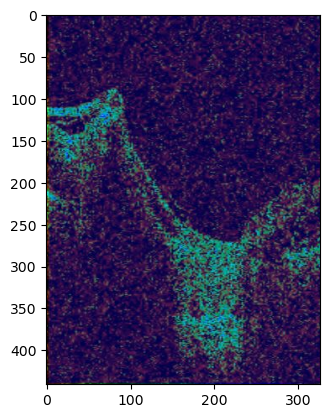

In [28]:
# Get the index of the upper border of the color scale bar (i.e., the first peak seen along the Y-axis)
upper_border = peak_indices.min() + 1 
    # added 1, since this first peak index is technically the index of a difference calculated between
    # the the row immediately above the color scale bar and the first/top row of the color scale bar
    # i.e., index 440 of row_scores plugged into bscanSC[440,:,:] gives a row of the part we want to keep
    # while bscanSC[441,:,:] is the very first row of the color scale bar.

# Subset bscanSC up to upper_border to crop out the color bar
bscan_cropped = bscanSC[:upper_border,:,:] # the indexing syntax excludes upper_border itself (hence why the +1 earlier)

_ = plt.imshow(bscan_cropped)

###### Composite Cropping Function 

In [29]:
def cropBSCAN(bscanInput,maskInput, 
              row_transition_threshold=50, 
              resample=1,
              showMode=None):

    bscan_array = vizInputParser(bscanInput)
    mask_array = vizInputParser(maskInput)
    
    # Get column indices to crop down to masked region
    dark_threshold = np.array([0,0,0])
    mask = np.any(mask_array > dark_threshold, axis=-1)
    bright_col_indices = np.unique(np.where(mask)[1])
    xmin, xmax = bright_col_indices[0], bright_col_indices[-1]

    # Get row indices to crop out horizontal color scale bar
    bscan_regint = bscan_array.astype(int)
    dVdY = np.diff(bscan_regint,axis=0)
    mag_dVdY = np.abs(dVdY)
    row_scores = mag_dVdY.mean(axis=(1,2))
    peak_indices = np.where(row_scores > row_transition_threshold)[0]
    cbar_upper_border = peak_indices.min() + 1 

    # Subset/crop original image
    cropped_bscan = bscan_array[ :cbar_upper_border, xmin:xmax, : ]

    # downsample for lightweight display by specified factor 0-1
    if resample !=1:
        bscan_array = cv2.resize(bscan_array, dsize=None, 
                                 fx=resample,fy=resample, 
                                 interpolation=cv2.INTER_AREA)
        
        cropped_bscan = cv2.resize(cropped_bscan, dsize=None, 
                                   fx=resample,fy=resample, 
                                   interpolation=cv2.INTER_AREA)
    
    # Parse output/end-action per kwargs
    if showMode in ['compare','comp','c']:
        fig,(left,right) = plt.subplots(1,2,figsize=(10,3))
        left.imshow(bscan_array)
        left.set_title('original')
        right.imshow(cropped_bscan)
        right.set_title('cropped')
    elif showMode in ['result','res','r']:
        plt.imshow(cropped_bscan)
    else:
        return cropped_bscan

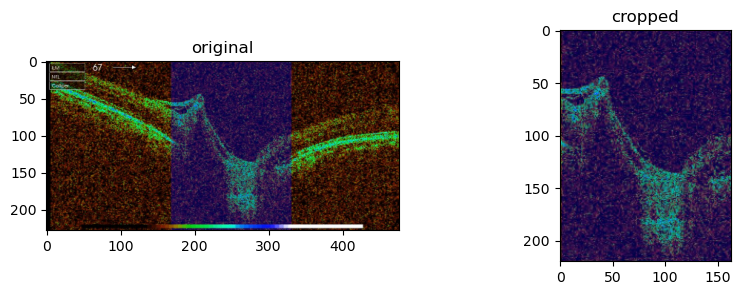

In [30]:
# Test out the function / preview after and before images:
cropBSCAN(scan['bscan_path'],scan['cup_path'],
          row_transition_threshold=50,
          showMode='compare', resample=.5)

In [31]:
# Wrapper function for cropBSCAN that allows patient record indexing, saving images, and more plotting/formatting options
def bscanCropDisp(index,df=bwm, mask_type='cup', row_transition_threshold=50,
                  save_to:str=None, custom_save_ext:str=None, overwrite=False, 
                  ax=None, show_titles=False, resample=1):

    # ======CROP===IMAGE====== #
    # --- Get B-scan path
    bscan_path = df.iloc[index].bscan_path

    # --- Parse mask path per kwarg
    if mask_type == 'cup':
        mask_path = df.iloc[index].cup_path
    elif mask_type == 'disc':
        mask_path = df.iloc[index].disc_path
    else:
        raise ValueError('Invalid mask_type.')
        
    # Crop b-scan using mask
    cropped_bscan_array = cropBSCAN(bscan_path,mask_path,
                                    row_transition_threshold = row_transition_threshold,
                                    resample = resample)

    # --- Unpack features for filename or plot titles --- #
    pin, le, glc = tuple(df["PIN left_eye glaucoma".split(' ')].iloc[index].values)
    

    # ===IMAGE==FILE==SAVING=== #
    if save_to:
        if save_to in ['cwd','pwd','.']:
            outDIR = os.getcwd()
        if os.path.isdir(save_to):
            outDIR = save_to
        else:
            os.makedirs(save_to)
            outDIR = save_to

        inFILE = os.path.basename(bscan_path)
        inBASE = os.path.splitext(inFILE)[0]
        inEXT = os.path.splitext(inFILE)[-1]

        if custom_save_ext:
            outEXT = custom_save_ext
        else:
            outEXT = inEXT

        outFILE = f"{inBASE}_cropped{outEXT}"
        outPATH = os.path.join(outDIR,outFILE)

        if not overwrite:
            copy_num=1
            while os.path.isfile(outPATH):
                outFILE = f"{inBASE}_cropped_{copy_num}{outEXT}"
                outPATH = os.path.join(outDIR,outFILE)
                copy_num += 1
                
        try:
            if outEXT == '.npy':
                np.save(outPATH, cropped_bscan_array)
            else:
                cv2.imwrite(outPATH,cropped_bscan_array)
            # print(f"Image saved to {outPATH}")
            return outPATH
        except:
            raise AssertionError(f"Unable to save {outFILE} image to {outPATH}")

    
    # =====IMAGE==PLOTTING===== #
    else:
        # i.e. if fig,ax not instantiated outside of this function call then plot as a single subplot
        if not ax:
            fig,ax=plt.subplots()
            
        ax.imshow(cropped_bscan_array)
        
        if show_titles:
            title = f"Pt. #{pin} | {'OS' if le else 'OD'} | {'Glaucoma' if glc else 'Normal'}"
            ax.set_title(title,fontsize=8)

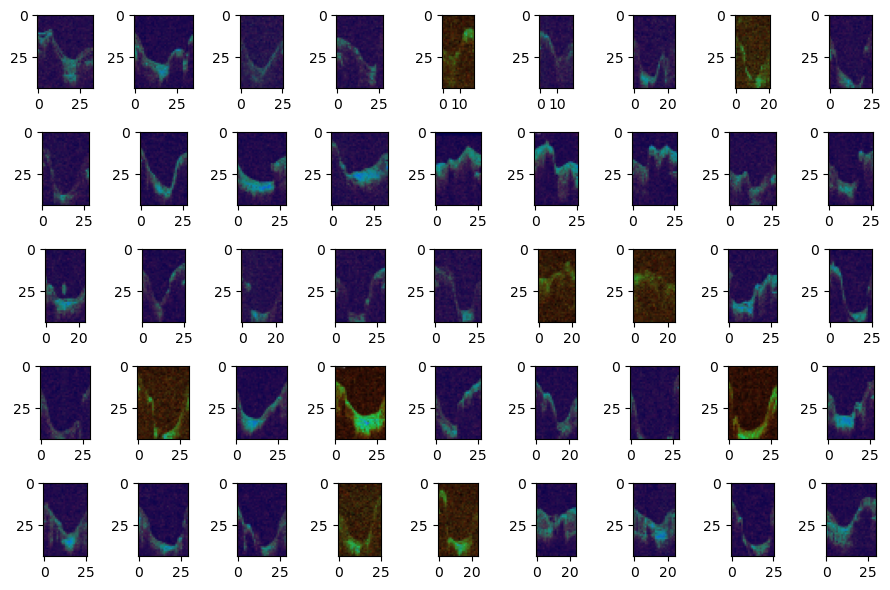

In [32]:
# Use wrapper function to preview all cropped images in `bwm` using this method
fig,ax = plt.subplots(5,9,figsize=(9,6))
for i in range(len(bwm)):
    bscanCropDisp(i,ax=ax.flat[i],resample=.1)
plt.tight_layout()

In [33]:
# Save arrays to new filepaths (can use .npy file extensions to further distinguish from the original JPEG images)

bwm_cropped_paths={}
savePATH = '../datasrc/fundus-oct-composite/cropped_bscan_arrays/'
for i in range(len(bwm)):
    oPATH = bscanCropDisp(i,save_to=savePATH,
                          overwrite=True,
                          custom_save_ext='.npy')
    bwm_cropped_paths[i]=oPATH

print(f"{len(bwm_cropped_paths)} of {len(bwm)} images saved to {savePATH}")

45 of 45 images saved to ../datasrc/fundus-oct-composite/cropped_bscan_arrays/


In [34]:
bwm.head(2)

dx_class  glaucoma  PIN laterality  left_eye  \
0  glaucoma         1  625         OS         1   
1  glaucoma         1  626         OD         0   

                                          bscan_path  \
0  ../datasrc/fundus-oct-composite/Glaucoma/P_1/L...   
1  ../datasrc/fundus-oct-composite/Glaucoma/P_2/R...   

                                            cup_path  \
0  ../datasrc/fundus-oct-composite/Glaucoma/P_1/L...   
1  ../datasrc/fundus-oct-composite/Glaucoma/P_2/R...   

                                           disc_path  
0  ../datasrc/fundus-oct-composite/Glaucoma/P_1/L...  
1  ../datasrc/fundus-oct-composite/Glaucoma/P_2/R...

In [35]:
# Add cropped image paths to bwm
bwm.insert(bwm.columns.get_loc('bscan_path')+1,
           'bscan_cropped_path',
           bwm_cropped_paths.values())

# Change b-scan to bscan_original
bwm = bwm.rename(columns={'bscan_path':'bscan_original_path'})

# Drop mask columns now that they have been used 
bwm = bwm.drop(columns=['cup_path','disc_path'])

# Preview
bwm.head(2)

dx_class  glaucoma  PIN laterality  left_eye  \
0  glaucoma         1  625         OS         1   
1  glaucoma         1  626         OD         0   

                                 bscan_original_path  \
0  ../datasrc/fundus-oct-composite/Glaucoma/P_1/L...   
1  ../datasrc/fundus-oct-composite/Glaucoma/P_2/R...   

                                  bscan_cropped_path  
0  ../datasrc/fundus-oct-composite/cropped_bscan_...  
1  ../datasrc/fundus-oct-composite/cropped_bscan_...

In [36]:
def ar_score(image_array, goal_ratio = 0.5): # 1:2 AR is the goal to match the ONH slices of the volume scans
    h,w,_ = image_array.shape
    aspect_ratio = w / h
    ar_error = np.abs(aspect_ratio - goal_ratio)
    return ar_error

# Calculate error scores (how much the cropped images deviate from the goal of 1:2)
ar_error_scores = bwm.bscan_cropped_path.apply(vizInputParser).apply(ar_score)

# Insert AR error scores as a column after bscan_cropped 
loc = bwm.columns.get_loc('bscan_cropped_path')+1
bwm.insert(loc, 'ar_error', ar_error_scores)

# Reset index, sort by ascending ar_error, and preview
bwm = bwm.reset_index().sort_values('ar_error').drop(columns='index')
bwm.head()


dx_class  glaucoma  PIN laterality  left_eye  \
23  glaucoma         1  638         OD         0   
7   glaucoma         1  629         OS         1   
18  glaucoma         1  635         OS         1   
20  glaucoma         1  636         OS         1   
40    normal         0  632         OS         1   

                                  bscan_original_path  \
23  ../datasrc/fundus-oct-composite/Glaucoma/P_14/...   
7   ../datasrc/fundus-oct-composite/Glaucoma/P_5/L...   
18  ../datasrc/fundus-oct-composite/Glaucoma/P_11/...   
20  ../datasrc/fundus-oct-composite/Glaucoma/P_12/...   
40  ../datasrc/fundus-oct-composite/Healthy/P_8/Le...   

                                   bscan_cropped_path  ar_error  
23  ../datasrc/fundus-oct-composite/cropped_bscan_...  0.005669  
7   ../datasrc/fundus-oct-composite/cropped_bscan_...  0.021542  
18  ../datasrc/fundus-oct-composite/cropped_bscan_...  0.032880  
20  ../datasrc/fundus-oct-composite/cropped_bscan_...  0.032880  
40  ../datasrc/fundus-oct-composite/cropped_bscan_...  0.051020

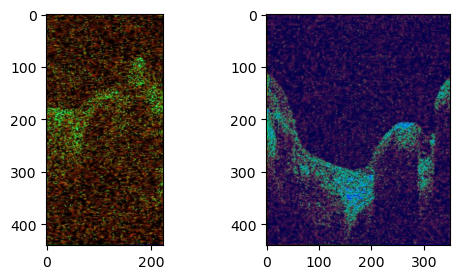

In [37]:
# View best and worst images by aspect ratio to check if scoring makes sense
best = vizInputParser(bwm.bscan_cropped_path.head(1).values[0])
worst = vizInputParser(bwm.bscan_cropped_path.tail(1).values[0])

_,(l,r)=plt.subplots(1,2,figsize=(6,3))
_ = l.imshow(best)
_ = r.imshow(worst)

#### Handling Images WITHOUT Accompanying Masks (`bOnly`)

##### Dataframe Reorganization

While the `bOnly` images might not have masks, at least some of them have shaded regions that would likely pertain to the cup region if following the same pattern as the rest of the images.  We can at least use these shadedareas and crop via using a similar method to cropping out the color scale bar, only in this case the color transition might truly be limited to a single channel, potentially making the job simpler. 

In [38]:
# Preview bOnly as it is currently
print(bOnly.shape);bOnly.head()

(34, 6)


dx_class  glaucoma  PIN laterality  left_eye  \
25  glaucoma         1  639         OD         0   
26  glaucoma         1  639         OS         1   
27  glaucoma         1  640         OS         1   
28  glaucoma         1  641         OD         0   
29  glaucoma         1  641         OS         1   

                                           bscan_path  
25  ../datasrc/fundus-oct-composite/Glaucoma/P_15/...  
26  ../datasrc/fundus-oct-composite/Glaucoma/P_15/...  
27  ../datasrc/fundus-oct-composite/Glaucoma/P_16/...  
28  ../datasrc/fundus-oct-composite/Glaucoma/P_17/...  
29  ../datasrc/fundus-oct-composite/Glaucoma/P_17/...

In [39]:
# Change column name in anticipation of future re-concatenating with `bwm` 
bOnly = bOnly.rename(columns={'bscan_path':'bscan_original_path'})

# Reset index
bOnly = bOnly.reset_index().drop(columns='index')

# Remove the `image_type` from the name for all columns
bOnly.columns.name = None

# Preview
bOnly.head()

dx_class  glaucoma  PIN laterality  left_eye  \
0  glaucoma         1  639         OD         0   
1  glaucoma         1  639         OS         1   
2  glaucoma         1  640         OS         1   
3  glaucoma         1  641         OD         0   
4  glaucoma         1  641         OS         1   

                                 bscan_original_path  
0  ../datasrc/fundus-oct-composite/Glaucoma/P_15/...  
1  ../datasrc/fundus-oct-composite/Glaucoma/P_15/...  
2  ../datasrc/fundus-oct-composite/Glaucoma/P_16/...  
3  ../datasrc/fundus-oct-composite/Glaucoma/P_17/...  
4  ../datasrc/fundus-oct-composite/Glaucoma/P_17/...

##### Screening for Croppable Images

As noted earlier, some of the images are shaded and some are not.  In the case of `bOnly`, there is no reliable option for cropping the unshaded ones as there are no expert-labeled mask images.  To parse out shaded vs. unshaded, we can use the color channels - namely the blue shading.

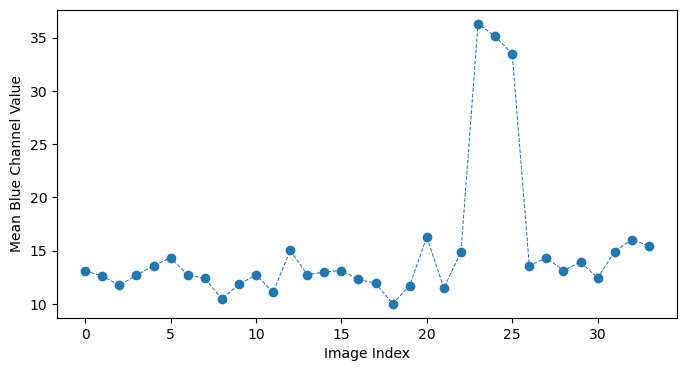

In [40]:
# Plot the average blue channel value of `bOnly` images with respect to their indices
meanblues = [ arr[:,:,2].mean() for arr in bOnly.bscan_original_path.apply(vizInputParser).values ]
plt.figure(figsize=(8,4))
plt.plot(meanblues, marker='o', ls='--',lw=0.75)
plt.xlabel('Image Index')
_ = plt.ylabel('Mean Blue Channel Value')

So there is a clear distinction between the three images vs. the rest - unfortunately, it would seem these three are the only shaded/croppable images in `bOnly` within the scope of this project.

In [41]:
# Subset only images with a mean blue channel value > 25
keep_indices = [ meanblues.index(mb) for mb in meanblues if mb > 25 ]

bOnly = bOnly.iloc[keep_indices]

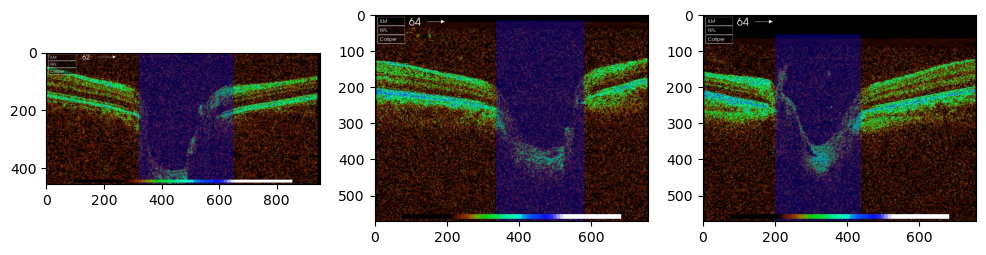

In [42]:
# View images
_ , (l,m,r) = plt.subplots(1,3,figsize=(12,6))
bOnly_paths = bOnly.bscan_original_path.values
_ = l.imshow(vizInputParser(bOnly_paths[0]))
_ = m.imshow(vizInputParser(bOnly_paths[1]))
_ = r.imshow(vizInputParser(bOnly_paths[2]))

Additionally, it looks like the last two images have an unwanted darker region above, so an additional vertical cropping step might be necessary in addition to cropping out the rainbow color bar at the bottom.

##### Cropping Example Image

In [43]:
# Take the 3rd image as an example
barr = bOnly.bscan_original_path.apply(vizInputParser).values[2].astype('uint8')

# Resized array for lightweight display
barr_small = cv2.resize(barr,dsize=None,
                        fx=0.1,fy=0.1,
                        interpolation=cv2.INTER_AREA)

# Preview shape
barr.shape, barr_small.shape

((572, 759, 3), (57, 76, 3))

###### Horizontal Cropping

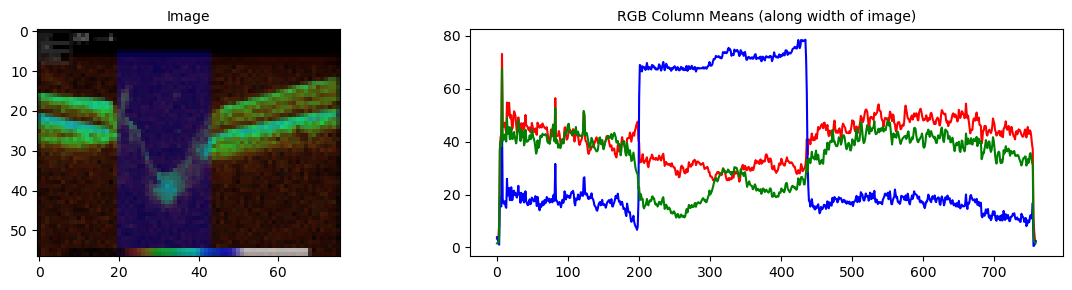

In [44]:
# Get means of each color channel along each column of the image (axis=0)
blue_cols = barr[:, :, 2].mean(axis=0)
green_cols = barr[:, :, 1].mean(axis=0)
red_cols = barr[:, :, 0].mean(axis=0)

fig,ax = plt.subplots(1,2,figsize=(12,3))
# fig.suptitle(ptscans(2)[1])
ax.flat[0].imshow(barr_small)
ax.flat[0].set_title(f'Image',fontsize=10)

ax.flat[1].plot(red_cols,c='r')
ax.flat[1].plot(blue_cols,c='b')
ax.flat[1].plot(green_cols,c='g')
ax.flat[1].set_title(f'RGB Column Means (along width of image)',fontsize=10)

plt.tight_layout()

Along the horizontal axis of the image, using the blue channel would seem to be effective

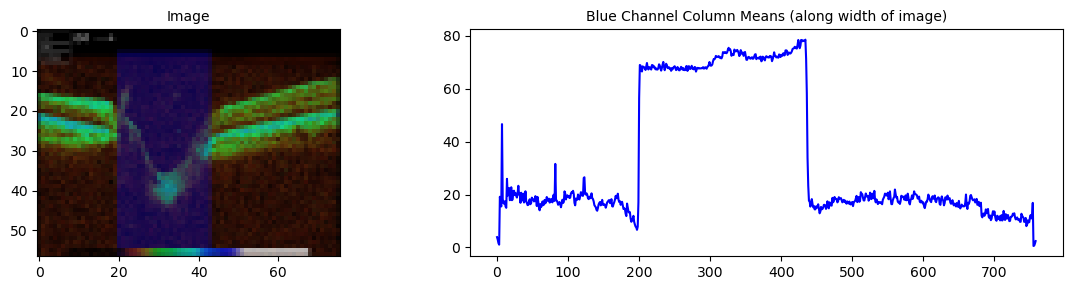

In [45]:
# Isolate blue channel

fig,ax = plt.subplots(1,2,figsize=(12,3))
# fig.suptitle(ptscans(2)[1])
ax.flat[0].imshow(barr_small)
ax.flat[0].set_title(f'Image',fontsize=10)
ax.flat[1].plot(blue_cols,c='b')
ax.flat[1].set_title(f'Blue Channel Column Means (along width of image)',fontsize=10)
plt.tight_layout()

And it looks like a threshold of 60 would do just fine.

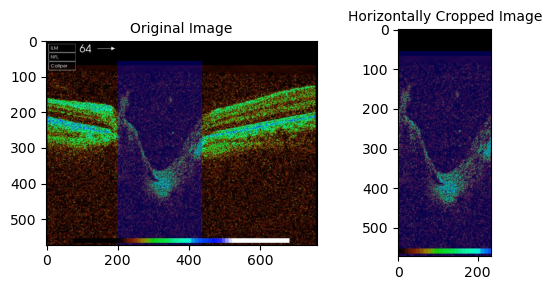

In [46]:
blue_threshold = 60
shaded_cols = np.where(blue_cols > blue_threshold)[0]

# Subset image to just shaded columns to crop
barrSC = barr[:,shaded_cols,:]

fig,ax = plt.subplots(1,2,figsize=(6,3))
# fig.suptitle(ptscans(2)[1])
ax.flat[0].imshow(barr)
ax.flat[0].set_title(f'Original Image',fontsize=10)
ax.flat[1].imshow(barrSC)
ax.flat[1].set_title(f'Horizontally Cropped Image',fontsize=10)
plt.tight_layout()

###### Vertical Cropping

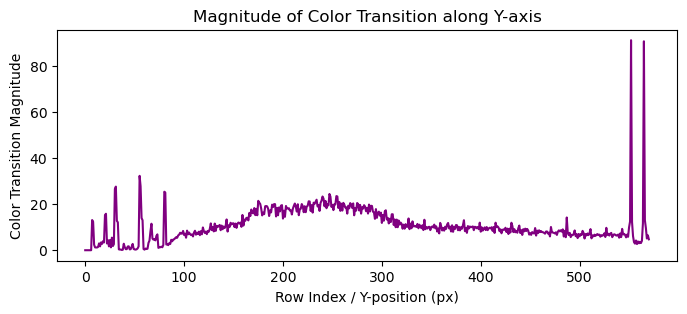

In [47]:
# Attempt row transition scoring, as done earlier for cropping out the color scale bar
barr = barr.astype(int)
dVdY = np.diff(barr,axis=0)
mag_dVdY = np.abs(dVdY)
row_scores = mag_dVdY.mean(axis=(1,2))
barr = barr.astype('uint8')

plt.figure(figsize=(8,3))
plt.title('Magnitude of Color Transition along Y-axis')
plt.xlabel('Row Index / Y-position (px)')
plt.ylabel('Color Transition Magnitude')
_ = plt.plot(np.arange(len(row_scores)),row_scores,c='purple')

In this case, the horizontal color scale bar has some clearly evident peaks at the bottom of the image, but the upper black portion that isn't part of the image is kind of cutting it close.  Perhaps examining a second-order transition may help, as there is still a noticeable peak relative to the local baseline right before row index 100 -- the issue as it is currently is that the "baseline" rises as it gets towards row indices 200-300.

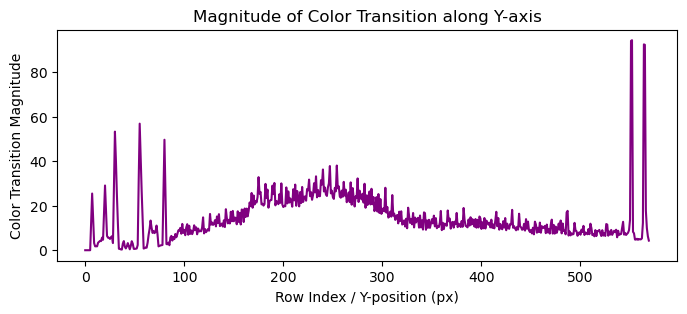

In [48]:
d2vdy2 = np.diff(dVdY,axis=0)
mag_d2vdy2 = np.abs(d2vdy2)
row_scores2 = mag_d2vdy2.mean(axis=(1,2))

plt.figure(figsize=(8,3))
plt.title('Magnitude of Color Transition along Y-axis')
plt.xlabel('Row Index / Y-position (px)')
plt.ylabel('Color Transition Magnitude')
_ = plt.plot(np.arange(len(row_scores2)),row_scores2,c='purple')

This may potentially work with a threshold of ~45, but still seems to be cutting it close (the central rise in the "baseline" was also amplified by this transformation).  That said, will consider looking at the color channels separately, given the success with horizontal cropping.

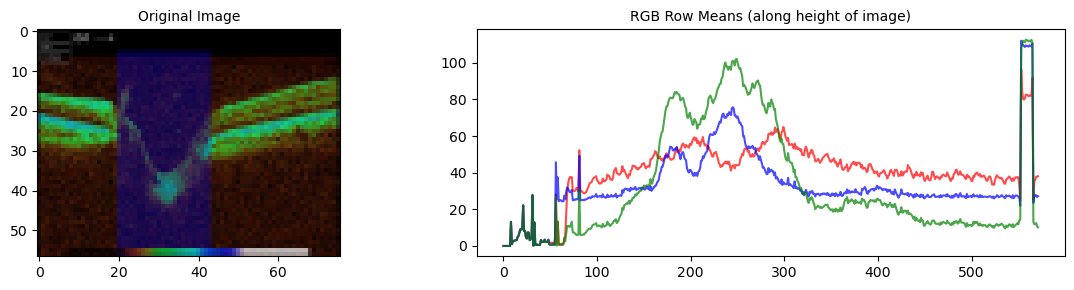

In [49]:
# Get means of each color channel along each row of the image (axis=1)
blue_row = barr[:, :, 2].mean(axis=1)
green_row = barr[:, :, 1].mean(axis=1)
red_row = barr[:, :, 0].mean(axis=1)

fig,ax = plt.subplots(1,2,figsize=(12,3))
# fig.suptitle(ptscans(2)[1])
ax.flat[0].imshow(barr_small)
ax.flat[0].set_title(f'Original Image',fontsize=10)
ax.flat[1].plot(red_row,c='r',alpha=0.7)
ax.flat[1].plot(blue_row,c='b', alpha=0.7)
ax.flat[1].plot(green_row,c='g', alpha=0.7)
ax.flat[1].set_title(f'RGB Row Means (along height of image)',fontsize=10)

plt.tight_layout()

If the black band at the top were purely uniform across all columns, the plot should essentially start out as a flatline and then sharply rise at the transition.  However, it seems like the white labels / legends on the top left are creating these smaller peaks.  We might get around this by subsetting only the right half of the image before calculating row means:

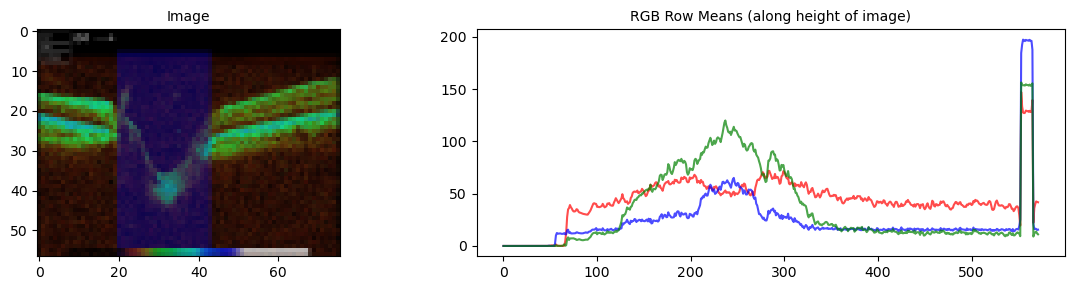

In [50]:
# Subsetting the right half of the image before taking row means
h,w,_ = barr.shape
blue_row = barr[:, int(w/2):, 2].mean(axis=1)
green_row = barr[:, int(w/2):, 1].mean(axis=1)
red_row = barr[:, int(w/2):, 0].mean(axis=1)

fig,ax = plt.subplots(1,2,figsize=(12,3))
# fig.suptitle(ptscans(2)[1])
ax.flat[0].imshow(barr_small)
ax.flat[0].set_title(f'Image',fontsize=10)
ax.flat[1].plot(red_row,c='r',alpha=0.7)
ax.flat[1].plot(blue_row,c='b', alpha=0.7)
ax.flat[1].plot(green_row,c='g', alpha=0.7)
ax.flat[1].set_title(f'RGB Row Means (along height of image)',fontsize=10)

plt.tight_layout()

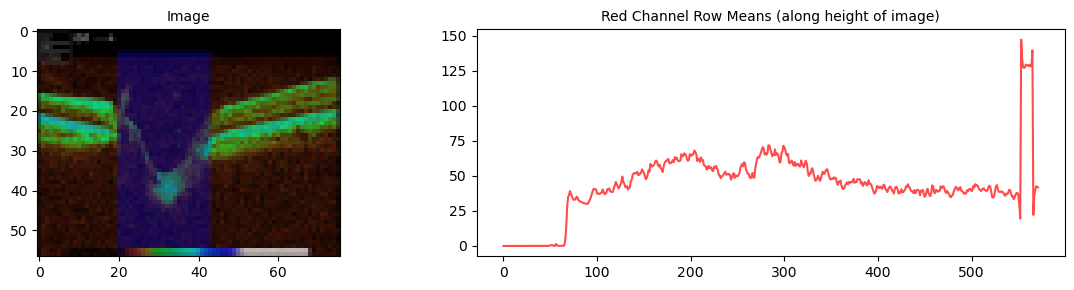

In [51]:
# View just the red channel
fig,ax = plt.subplots(1,2,figsize=(12,3))
# fig.suptitle(ptscans(2)[1])
ax.flat[0].imshow(barr_small)
ax.flat[0].set_title(f'Image',fontsize=10)
ax.flat[1].plot(red_row,c='r',alpha=0.7)
ax.flat[1].set_title(f'Red Channel Row Means (along height of image)',fontsize=10)

plt.tight_layout()

Now we can likely use a threshold of 20 (crop out anything with values below) for the red channel to crop out the black band at the top, and 100 (crop out anything with values above) to crop out the color scale bar.

In [52]:
# Establish min and max thresholds for red as determined above
redmin, redmax = 20,100

# Subset row indices for which red_row falls within redmin and redmax
barr_row_indices = np.where((red_row > redmin) & (red_row < redmax))

# Subset the sidecropped array (barrSC) by the selected indices 
# to vertically crop the already horizontally cropped array  
barr_cropped = barrSC[barr_row_indices]

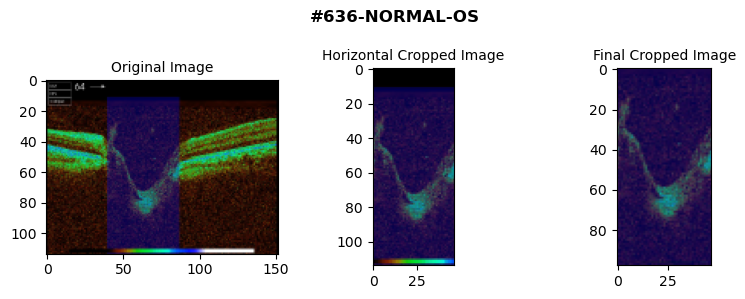

In [53]:
# PREVIEW PROGRESSIVE RESULTS - original, horizontal crop only, both horiz and vert crop

# For lightweight display, downsample the images
downscale = lambda img,scale : cv2.resize(img,dsize=None,
                                          fx=scale,fy=scale,
                                          interpolation=cv2.INTER_AREA)
scale = 0.2
barr_small = downscale(barr,scale)
barrSC_small = downscale(barrSC,scale)
barr_cropped_small = downscale(barr_cropped,scale)

# Plot images
fig,ax = plt.subplots(1,3,figsize=(8,3))
suptitle_elements = bOnly.iloc[2][['PIN','dx_class','laterality']].str.upper()
suptitle = "#"+'-'.join(suptitle_elements)
fig.suptitle(suptitle, fontweight='bold')
ax.flat[0].imshow(barr_small)
ax.flat[0].set_title(f'Original Image',fontsize=10)
ax.flat[1].imshow(barrSC_small)
ax.flat[1].set_title(f'Horizontal Cropped Image',fontsize=10)
ax.flat[2].imshow(barr_cropped_small)
ax.flat[2].set_title(f'Final Cropped Image',fontsize=10)
plt.tight_layout()

##### Cropping all three shaded `bOnly` images

In [54]:
# Custom cropping function for shaded images without accompanying mask images
def cropbyShadedRegion(img, blue_min=60, red_MinMax=(20,100), preview=False, ax=None, resample=1):
    # HORIZONTAL CROPPING PREP - getting column indices
    # Get mean of blue color channel along every column of the image (axis=0)
    blue_col = img[:, :, 2].mean(axis=0)
    # Get column indices where blue_col is above blue_min threshold
    shaded_cols = np.where(blue_col > blue_min)[0]
   
    # VERTICAL CROPPING PREP - getting row indices
    h,w,_ = img.shape
    # Get mean of red color channel along the RIGHT HALF of every row of the image (axis=1)
    red_row = img[:, int(w/2):, 0].mean(axis=1)
    # Get row indices where red_row is within the (redmin, redmax) interval
    redmin, redmax = red_MinMax
    image_rows = np.where((red_row > redmin) & (red_row < redmax))[0]

    # CROP IMAGE
    # Horizontal Crop - crop out the unshaded regions on the sides
    img_cropped_sides = img[:,shaded_cols,:]
    # Vertical Crop - crop out any black regions above and the rainbow color bar below
    img_cropped_final = img_cropped_sides[image_rows,:,:]

    # Resample for lightweight display if specified
    if resample < 1 and resample > 0:
        try:
            img_cropped_final = cv2.resize(img_cropped_final,dsize=None,
                                           fx=resample,fy=resample,
                                           interpolation=cv2.INTER_AREA)
        except: # i.e., if non-numeric or numeric >=1 or <=0 is passed into `resample` kwarg
            # image just won't be resized
            pass

    # Plot preview of the cropped image vs. return the image array
    if preview:
        if not ax:
            _,ax=plt.subplots(1,1)
        ax.imshow(img_cropped_final)
    else:
        return img_cropped_final

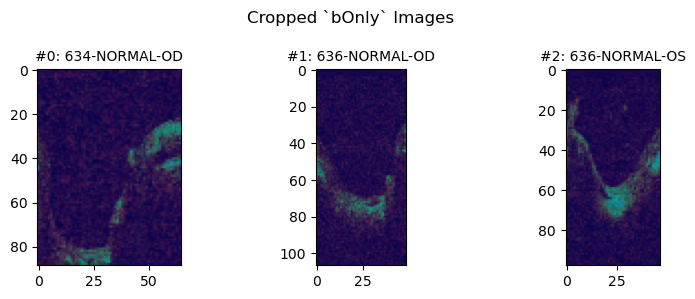

In [55]:
# Preview cropped images based on this method/pipeline/function
fig,ax = plt.subplots(1,3,figsize=(8,3))
# fig.suptitle(ptscans(2)[1])
for i,arr in enumerate(bOnly.bscan_original_path.apply(vizInputParser)):
    cropbyShadedRegion(arr,preview=True,ax=ax.flat[i],resample=0.2)
    axtitle_elements = bOnly.iloc[i][['PIN','dx_class','laterality']].str.upper()
    axtitle = f"#{i}: " + '-'.join(axtitle_elements)
    ax.flat[i].set_title(axtitle,fontsize=10)
    fig.suptitle('Cropped `bOnly` Images')
plt.tight_layout()

##### Saving Cropped Images & Re-concatenating Back With `bwm`

In [56]:
# Save arrays to ../datasrc/fundus-oct-composite/cropped_bscans/ using the same naming convention
bOnly_cropped_paths = []
for i, arr in enumerate(bOnly.bscan_original_path.apply(vizInputParser).apply(cropbyShadedRegion)):
    iPATH = bOnly.bscan_original_path.iloc[i]
    iNAME = os.path.basename(iPATH)
    nBASE = os.path.splitext(iNAME)[0]
    nEXT = os.path.splitext(iNAME)[1]

    # oNAME = nBASE + '_cropped' + nEXT
    oNAME = nBASE + '_cropped.npy'
    oDIR = '../datasrc/fundus-oct-composite/cropped_bscan_arrays/'
    oPATH = os.path.join(oDIR,oNAME)

    try:
        cv2.imwrite(oPATH,arr)
        bOnly_cropped_paths.append(oPATH)
    except:
        try:
            np.save(oPATH,arr)
            bOnly_cropped_paths.append(oPATH)
        except:
            raise AssertionError(f'Could not save {oPATH}')

print(f"{len(bOnly)} of {len(bOnly)} images saved to {oDIR}")

3 of 3 images saved to ../datasrc/fundus-oct-composite/cropped_bscan_arrays/


In [57]:
# Add columns for cropped paths along with aspect ratio error score, as done with `bwm` 
bOnly['bscan_cropped_path'] = bOnly_cropped_paths
bOnly['ar_error'] = bOnly.bscan_cropped_path.apply(vizInputParser).apply(ar_score)
bwm.columns.name = None
bOnly

dx_class  glaucoma  PIN laterality  left_eye  \
23   normal         0  634         OD         0   
24   normal         0  636         OD         0   
25   normal         0  636         OS         1   

                                  bscan_original_path  \
23  ../datasrc/fundus-oct-composite/Healthy/P_10/R...   
24  ../datasrc/fundus-oct-composite/Healthy/P_12/R...   
25  ../datasrc/fundus-oct-composite/Healthy/P_12/L...   

                                   bscan_cropped_path  ar_error  
23  ../datasrc/fundus-oct-composite/cropped_bscan_...  0.233184  
24  ../datasrc/fundus-oct-composite/cropped_bscan_...  0.045624  
25  ../datasrc/fundus-oct-composite/cropped_bscan_...  0.020408

In [58]:
# Concatenate into a single dataframe of cropped 2D B-scans (still SET 2 only) for further processing together
bscans = pd.concat([bOnly,bwm],axis=0).reset_index(drop=True)

print(bscans.shape,'\n')
bscans.info()
print()
bscans.head(3)

(48, 8) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dx_class             48 non-null     object 
 1   glaucoma             48 non-null     int64  
 2   PIN                  48 non-null     object 
 3   laterality           48 non-null     object 
 4   left_eye             48 non-null     int64  
 5   bscan_original_path  48 non-null     object 
 6   bscan_cropped_path   48 non-null     object 
 7   ar_error             48 non-null     float64
dtypes: float64(1), int64(2), object(5)
memory usage: 3.1+ KB



dx_class  glaucoma  PIN laterality  left_eye  \
0   normal         0  634         OD         0   
1   normal         0  636         OD         0   
2   normal         0  636         OS         1   

                                 bscan_original_path  \
0  ../datasrc/fundus-oct-composite/Healthy/P_10/R...   
1  ../datasrc/fundus-oct-composite/Healthy/P_12/R...   
2  ../datasrc/fundus-oct-composite/Healthy/P_12/L...   

                                  bscan_cropped_path  ar_error  
0  ../datasrc/fundus-oct-composite/cropped_bscan_...  0.233184  
1  ../datasrc/fundus-oct-composite/cropped_bscan_...  0.045624  
2  ../datasrc/fundus-oct-composite/cropped_bscan_...  0.020408

### Size/Scale

As seen earlier in this notebook for lightweight display images, we will use the `cv2.resize()` to downscale the cropped 2D B-scan images so that they match the same image dimensions as slices taken along axis 0 of the OCT volumes.  We will start out using area-based interpolation (`cv2.INTER_AREA`) as, according to the [documentation](https://docs.opencv.org/3.4/da/d54/group__imgproc__transform.html), this should result in the best appearance when shrinking images despite being slower than `cv2.INTER_LINEAR`.

Unlike earlier, where resizing was done by a factor applied to each axis (`fx=`,`fy=`), the second positional argument (`dsize=`) allows for exact desired dimensions (64 x 128 in this case) to be specified for the resulting image.   

#### Downsampling Example Image

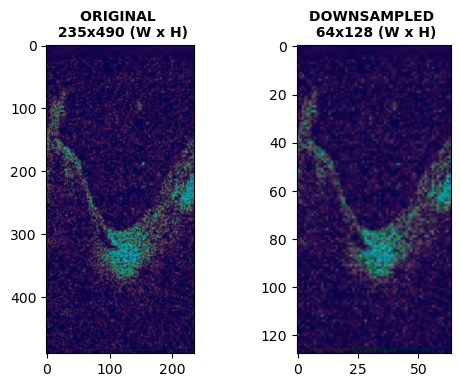

In [59]:
# Resize the cropped example image from earlier to specifically 64 x 128 this time
barr_cropped_downsized = cv2.resize(barr_cropped,(64,128), cv2.INTER_AREA)

# Plot original and downsampled images for visual comparison
_,(before,after) = plt.subplots(1,2, figsize=(6,4))

h,w,_ = barr_cropped.shape
before.set_title(f'ORIGINAL \n {w}x{h} (W x H)',fontsize=10,fontweight='bold')
before.imshow(barr_cropped)

dh,dw,_ = barr_cropped_downsized.shape
after.set_title(f'DOWNSAMPLED \n {dw}x{dh} (W x H)',fontsize=10,fontweight='bold')
_ = after.imshow(barr_cropped_downsized)

#### Downsampling all cropped B-scans (`bscans` DataFrame)

In [60]:
downsampled_paths=[]

saveDIR = '../datasrc/fundus-oct-composite/downsampled/'
if not os.path.isdir(saveDIR):
    os.makedirs(saveDIR)

for i, cropped_path in enumerate(bscans.bscan_cropped_path):
    cropped_arr = vizInputParser(cropped_path)
    downsampled_arr = cv2.resize(cropped_arr,(64,128),cv2.INTER_AREA)

    inFILE = os.path.basename(cropped_path)
    inBASE = os.path.splitext(inFILE)[0]
    outFILE = f"{inBASE}_64x128px.npy"
    outPATH = os.path.join(saveDIR,outFILE)

    try:
        np.save(outPATH,downsampled_arr)
        downsampled_paths.append(outPATH)
    except:
        print(f"Unable to write {outFILE} to path: {outPATH}")

print(f"{len(downsampled_paths)} of {len(bscans)} images saved in {saveDIR}")

48 of 48 images saved in ../datasrc/fundus-oct-composite/downsampled/


In [61]:
bscans.insert(len(bscans.T)-1, 'bscan_downsampled_path', downsampled_paths)
bscans.head()

dx_class  glaucoma  PIN laterality  left_eye  \
0    normal         0  634         OD         0   
1    normal         0  636         OD         0   
2    normal         0  636         OS         1   
3  glaucoma         1  638         OD         0   
4  glaucoma         1  629         OS         1   

                                 bscan_original_path  \
0  ../datasrc/fundus-oct-composite/Healthy/P_10/R...   
1  ../datasrc/fundus-oct-composite/Healthy/P_12/R...   
2  ../datasrc/fundus-oct-composite/Healthy/P_12/L...   
3  ../datasrc/fundus-oct-composite/Glaucoma/P_14/...   
4  ../datasrc/fundus-oct-composite/Glaucoma/P_5/L...   

                                  bscan_cropped_path  \
0  ../datasrc/fundus-oct-composite/cropped_bscan_...   
1  ../datasrc/fundus-oct-composite/cropped_bscan_...   
2  ../datasrc/fundus-oct-composite/cropped_bscan_...   
3  ../datasrc/fundus-oct-composite/cropped_bscan_...   
4  ../datasrc/fundus-oct-composite/cropped_bscan_...   

                              bscan_downsampled_path  ar_error  
0  ../datasrc/fundus-oct-composite/downsampled/28...  0.233184  
1  ../datasrc/fundus-oct-composite/downsampled/16...  0.045624  
2  ../datasrc/fundus-oct-composite/downsampled/16...  0.020408  
3  ../datasrc/fundus-oct-composite/downsampled/14...  0.005669  
4  ../datasrc/fundus-oct-composite/downsampled/10...  0.021542

### Image Color Values

To make the 2D images more consistent with the grayscale slices that will be extracted from the volumes, the cropped B-scans must ultimately be converted to grayscale as well.  That said, the images as they currently are now have two distinct artificial clusters due to some being shaded in blue and some not.  It may be of utility to "unshade" the shaded images prior to converting all of the images to grayscale. 

As done earlier, the mean blue channel can be isolated for each image and plotted in order to determine an appropriate threshold / boundary for categorizing "shaded" vs. "unshaded":

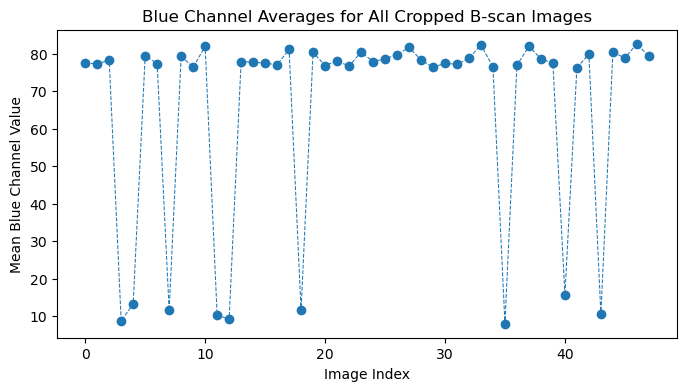

In [62]:
# Plot the average blue channel value of cropped bscan images with respect to their indices
meanblues = [ arr[:,:,2].mean() for arr in bscans.bscan_downsampled_path.apply(vizInputParser).values ]
plt.figure(figsize=(8,4))
plt.title('Blue Channel Averages for All Cropped B-scan Images')
plt.plot(meanblues, marker='o', ls='--',lw=0.75)
plt.xlabel('Image Index')
_ = plt.ylabel('Mean Blue Channel Value')

So we could easily use a threshold of 50, for example, to automatically categorize images as "shaded" vs. "unshaded" -- will use mean blue channel value > 50 to indicate shaded, and < 50 to indicate unshaded. 

In [63]:
# Add column to categorize images as shaded vs. unshaded based on threshold of blue channel mean > 50 --> shaded
def is_shaded(vizIn):
    arr = vizInputParser(vizIn)
    blumean = arr[:,:,2].mean()
    if blumean > 50:
        return True
    else:
        return False
    
bscans.insert(loc=bscans.columns.get_loc('bscan_original_path'),
              column='shaded',
              value=bscans.bscan_downsampled_path.apply(is_shaded)
             )

bscans.head()

dx_class  glaucoma  PIN laterality  left_eye  shaded  \
0    normal         0  634         OD         0    True   
1    normal         0  636         OD         0    True   
2    normal         0  636         OS         1    True   
3  glaucoma         1  638         OD         0   False   
4  glaucoma         1  629         OS         1   False   

                                 bscan_original_path  \
0  ../datasrc/fundus-oct-composite/Healthy/P_10/R...   
1  ../datasrc/fundus-oct-composite/Healthy/P_12/R...   
2  ../datasrc/fundus-oct-composite/Healthy/P_12/L...   
3  ../datasrc/fundus-oct-composite/Glaucoma/P_14/...   
4  ../datasrc/fundus-oct-composite/Glaucoma/P_5/L...   

                                  bscan_cropped_path  \
0  ../datasrc/fundus-oct-composite/cropped_bscan_...   
1  ../datasrc/fundus-oct-composite/cropped_bscan_...   
2  ../datasrc/fundus-oct-composite/cropped_bscan_...   
3  ../datasrc/fundus-oct-composite/cropped_bscan_...   
4  ../datasrc/fundus-oct-composite/cropped_bscan_...   

                              bscan_downsampled_path  ar_error  
0  ../datasrc/fundus-oct-composite/downsampled/28...  0.233184  
1  ../datasrc/fundus-oct-composite/downsampled/16...  0.045624  
2  ../datasrc/fundus-oct-composite/downsampled/16...  0.020408  
3  ../datasrc/fundus-oct-composite/downsampled/14...  0.005669  
4  ../datasrc/fundus-oct-composite/downsampled/10...  0.021542

Will now attempt unshading of a shaded image by subtracting average differences in color channels between the shaded and unshaded subgroups of all the images. 

In [64]:
# Define functions to get means of each color channel for a given set of images
def ccmeans(img):
    # Gets mean of each color for a single image
    img = vizInputParser(img)
    iflat = img.flatten().reshape(-1,3)
    r,g,b = [iflat[:,i].mean() for i in range(3)]
    return np.array([r,g,b])

def overall_ccmeans(images):
    # Gets mean of each color for a set of images
    images = [vizInputParser(img) for img in images]
    all_ccmeans = np.array([ ccmeans(img) for img in images ])
    return all_ccmeans.mean(axis=0)

# Define function to "unshade" an image using the mean in color channel differences betweeen sets of shaded and unshaded images
def unshade(shaded_img,unshaded_paths,shaded_paths,preview=True):
    # Ensure input for shaded_img gets converted to array for processing
    shaded_img = vizInputParser(shaded_img)
    
    # Caluclate the mean differences in color channels between the unshaded and shaded images
    mean_ccdiff = overall_ccmeans(shaded_paths) - overall_ccmeans(unshaded_paths)

    # Unshade the shaded image by subtracting the mean differences in color channels
    unshaded_img = np.clip(shaded_img - mean_ccdiff,0,255).astype('uint8')

    if preview:
        _,(l,r) = plt.subplots(1,2,figsize=(6,4))
        l.imshow(shaded_img)
        l.set_title('Before')
        r.imshow(unshaded_img)
        r.set_title('After')
    else:
        return unshaded_img

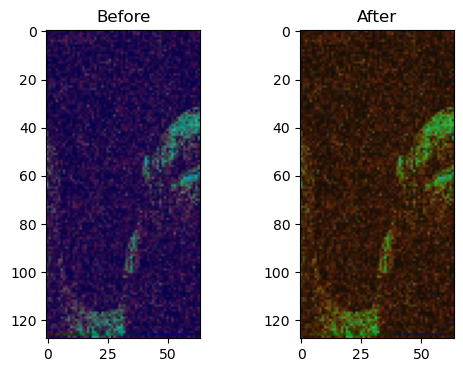

In [65]:
# Subset unshaded vs shaded paths
unshaded_paths = bscans[~bscans.shaded].bscan_downsampled_path.values
shaded_paths = bscans[bscans.shaded].bscan_downsampled_path.values

# Preview / compare an original shaded image to the artificially unshaded version: 
unshade(shaded_paths[0],unshaded_paths,shaded_paths)

We can now combine this with `cv2.cvtColor()` for converting images to grayscale.  In this case, judging by the appearance of the image and the fact that cv2 reads in color images in BGR format, will be using `cv2.COLOR_BGR2GRAY`.

In [66]:
# Unshade & convert all downsampled images to grayscale, save, and store paths in list
gray_paths = []

saveDIR = '../datasrc/fundus-oct-composite/grayscale/'
if not os.path.isdir(saveDIR):
    os.makedirs(saveDIR)

for i,path in enumerate(bscans.bscan_downsampled_path):
    arr = vizInputParser(path)
    unshaded = unshade(arr,unshaded_paths,shaded_paths,preview=False)
    gray = cv2.cvtColor(unshaded,cv2.COLOR_BGR2GRAY)

    inFILE = os.path.basename(path)
    inBASE = os.path.splitext(inFILE)[0]
    outFILE = f"{inBASE}_gray.npy"
    outPATH = os.path.join(saveDIR,outFILE)
    
    try:
        np.save(outPATH,gray)
        gray_paths.append(outPATH)
    except:
        print(f"Unable to write {outFILE} to path: {outPATH}")

print(f"{len(gray_paths)} of {len(bscans)} images saved in {saveDIR}")

48 of 48 images saved in ../datasrc/fundus-oct-composite/grayscale/


In [67]:
# Add gray_paths to `bscans` as a new column
bscans.insert(bscans.columns.get_loc('left_eye')+1,"bscan_final_path",gray_paths)
bscans.head()

dx_class  glaucoma  PIN laterality  left_eye  \
0    normal         0  634         OD         0   
1    normal         0  636         OD         0   
2    normal         0  636         OS         1   
3  glaucoma         1  638         OD         0   
4  glaucoma         1  629         OS         1   

                                    bscan_final_path  shaded  \
0  ../datasrc/fundus-oct-composite/grayscale/2810...    True   
1  ../datasrc/fundus-oct-composite/grayscale/1671...    True   
2  ../datasrc/fundus-oct-composite/grayscale/1671...    True   
3  ../datasrc/fundus-oct-composite/grayscale/1491...   False   
4  ../datasrc/fundus-oct-composite/grayscale/1091...   False   

                                 bscan_original_path  \
0  ../datasrc/fundus-oct-composite/Healthy/P_10/R...   
1  ../datasrc/fundus-oct-composite/Healthy/P_12/R...   
2  ../datasrc/fundus-oct-composite/Healthy/P_12/L...   
3  ../datasrc/fundus-oct-composite/Glaucoma/P_14/...   
4  ../datasrc/fundus-oct-composite/Glaucoma/P_5/L...   

                                  bscan_cropped_path  \
0  ../datasrc/fundus-oct-composite/cropped_bscan_...   
1  ../datasrc/fundus-oct-composite/cropped_bscan_...   
2  ../datasrc/fundus-oct-composite/cropped_bscan_...   
3  ../datasrc/fundus-oct-composite/cropped_bscan_...   
4  ../datasrc/fundus-oct-composite/cropped_bscan_...   

                              bscan_downsampled_path  ar_error  
0  ../datasrc/fundus-oct-composite/downsampled/28...  0.233184  
1  ../datasrc/fundus-oct-composite/downsampled/16...  0.045624  
2  ../datasrc/fundus-oct-composite/downsampled/16...  0.020408  
3  ../datasrc/fundus-oct-composite/downsampled/14...  0.005669  
4  ../datasrc/fundus-oct-composite/downsampled/10...  0.021542

In [68]:
# verify absence of color channels in `bscan_final_path`
bscans.bscan_final_path.apply(vizInputParser).apply(np.shape).unique()

array([(128, 64)], dtype=object)

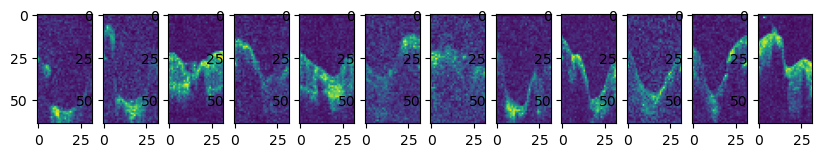

In [69]:
# Test out loading files from their file paths to validate proper saving / indexing
N=12
initial=6

nrows,ncols = GridDimensionOptimizer().optimal_grid(N)
_,ax = plt.subplots(1,N,figsize=(10,4))
axf = ax.flat

for i,path in enumerate(bscans.bscan_final_path.iloc[initial:initial+N]):
    arr = vizInputParser(path)
    arr = downscale(arr,0.5)
    axf[i].imshow(arr)

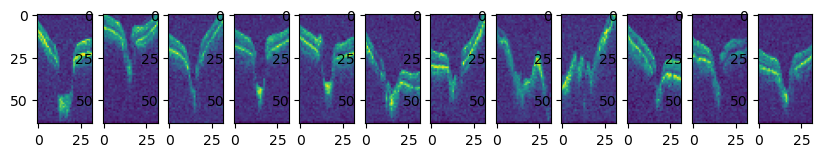

In [70]:
# Display various middle slices normal to axis 0 of the volumes for comparison
_,ax = plt.subplots(1,12,figsize=(10,4))
axf = ax.flat

for i, index in enumerate(range(9,21)):
    vslice = crossSection(vMeta.filepath.iloc[index])[0]
    vslice = downscale(vslice,0.5)
    axf[i].imshow(vslice)

# plt.tight_layout()

In [71]:
# Remove intermediary pre-processing columns not relevant to modeling
bscans_preprocessing = pd.DataFrame(bscans) # Create preprocessing df copy just in case
col_cutoff = bscans_preprocessing.columns.get_loc('bscan_final_path') + 1
bscans = bscans_preprocessing.iloc[:,:col_cutoff]
# Convert column name back to "filepath" and add back `set` column in preparation for merging back with the main dataset
bscans.rename(columns={'bscan_final_path':'filepath'},inplace=True)
bscans.insert(len(bscans.T)-1,'set',2)
bscans.head()

dx_class  glaucoma  PIN laterality  left_eye  set  \
0    normal         0  634         OD         0    2   
1    normal         0  636         OD         0    2   
2    normal         0  636         OS         1    2   
3  glaucoma         1  638         OD         0    2   
4  glaucoma         1  629         OS         1    2   

                                            filepath  
0  ../datasrc/fundus-oct-composite/grayscale/2810...  
1  ../datasrc/fundus-oct-composite/grayscale/1671...  
2  ../datasrc/fundus-oct-composite/grayscale/1671...  
3  ../datasrc/fundus-oct-composite/grayscale/1491...  
4  ../datasrc/fundus-oct-composite/grayscale/1091...

### Array Spatial Dimensions

Fairly straightforward - extracting slices from the middle of all volumes (SET 1) along axis 0, such that we have only 2D grayscale arrays that resemble the final bscans.

In [72]:
# extract slices from volumes
slicepaths = []

oDIR = '../datasrc/volumesOCT/bslices/'
if not os.path.isdir(oDIR):
    os.makedirs(oDIR)

for ri,path in enumerate(vMeta.filepath):
    volume_slice = crossSection(path,axis_norm=0,slice_depth=0.5)
    arr, sdata = volume_slice
    si = sdata['slice_index']
    sd = sdata['slice_depth']
    nax = sdata['axis_norm']
    
    iFILE = os.path.basename(path)
    iBASE = os.path.splitext(iFILE)[0]
    oFILE = f"{iBASE}_ax{nax}-slice{si}-sd{int(sd*100)}.npy"
    oPATH = os.path.join(oDIR,oFILE)

    try:
        np.save(oPATH,arr)
        slicepaths.append(oPATH)
    except:
        raise AssertionError('Unable to save slice')

print(f"{len(slicepaths)} of {len(vMeta)} slices extracted and saved to {oDIR}")

1110 of 1110 slices extracted and saved to ../datasrc/volumesOCT/bslices/


In [73]:
# Add slicepaths to new dataframe based on `vMeta` but without image_type,patient_id or the original volume filepaths
vslices = vMeta.drop(['filepath','image_type','patient_id'],axis=1)
vslices['filepath'] = slicepaths
vslices.head(1)

dx_class  glaucoma  PIN laterality  left_eye  set  \
826   normal         0  001         OD         0    1   

                                              filepath  
826  ../datasrc/volumesOCT/bslices/Normal-000002-20...

In [74]:
# Verifying column headers identical column headers to `bscans` before concatenation
bscans.head(1)

dx_class  glaucoma  PIN laterality  left_eye  set  \
0   normal         0  634         OD         0    2   

                                            filepath  
0  ../datasrc/fundus-oct-composite/grayscale/2810...

In [75]:
# Combine both 2D image sets (volume slices and bscans) into one composite set
cdf = pd.concat([vslices,bscans],axis=0)
cdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1158 entries, 826 to 47
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   dx_class    1158 non-null   object
 1   glaucoma    1158 non-null   int64 
 2   PIN         1158 non-null   object
 3   laterality  1158 non-null   object
 4   left_eye    1158 non-null   int64 
 5   set         1158 non-null   int64 
 6   filepath    1158 non-null   object
dtypes: int64(3), object(4)
memory usage: 72.4+ KB


### Pixel Intensities 

In [76]:
# Custom function for plotting pixel intensities
def pixIhist(vizIn,fixed_xrange=True,ax=None,color=None):
    arr = vizInputParser(vizIn)
    aflat = arr.flatten()
    aflat.sort()
    nbins = int(len(aflat) / np.sqrt(len(aflat)))

    if not ax:
        _,ax=plt.subplots()

    if fixed_xrange:
        xmin,xmax=0,255
        ax.set_xlim(xmin,xmax)
        ax.set_xticks(np.arange(0,272,32))
        ax.tick_params(axis='x',labelsize=8)
        ax.tick_params(axis='y',labelsize=8)
        xrange_str = f" ({xmin}-{xmax})"
    else:
        xrange_str = ''
        
    ax.hist(aflat,bins=nbins,color=color)
    ax.set_xlabel(f'Pixel Intensity{xrange_str}')
    ax.set_ylabel('N_pixels')
    
    plt.tight_layout()

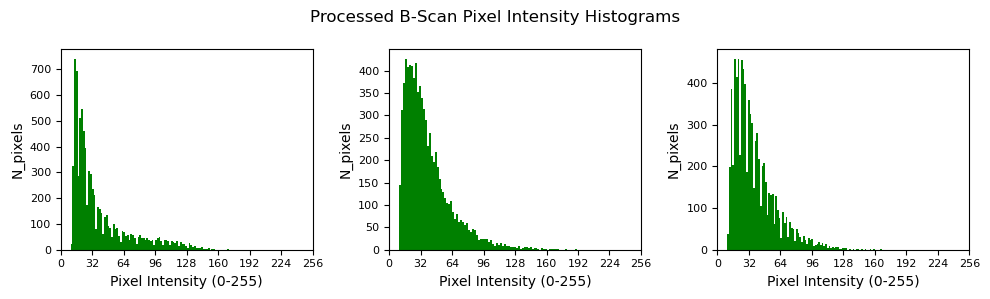

In [77]:
# Plot some sample histograms for the processed b-scans
fig,ax=plt.subplots(1,3,figsize=(10,3))
fig.suptitle('Processed B-Scan Pixel Intensity Histograms')
for i in range(3):
    fp = cdf[cdf.set==2].filepath.values[i+10]
    pixIhist(fp,ax=ax.flat[i],color='green')

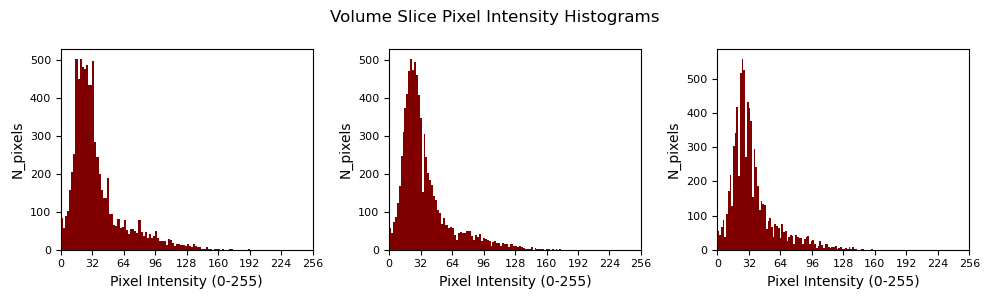

In [78]:
# Plot the same for volumes to compare
fig,ax=plt.subplots(1,3,figsize=(10,3))
fig.suptitle('Volume Slice Pixel Intensity Histograms')
for i in range(3):
    fp = cdf[cdf.set==1].filepath.values[i+123]
    pixIhist(fp,ax=ax.flat[i],color='maroon')

Some of this was already observed during EDA, but now with the b-scan images cropped, unshaded, downsized, etc... it can be said about all the images that the pixel intensity histograms deviate from normality in the following ways:

+ All are right-skewed
+ Some have spikes scattered throughout instead of a smooth curve
+ Some notable differences in kurtosis, particularly between the separate sets.

This is to be expected, as perfectly normal histograms would represent random noise (Gaussian noise) -essentially meaningless images.  Most if not all of these deviations are likely to represent the actual image features.

---

Since image pixel intensity values are inherently fixed within 0-255, there is less concern for outliers affecting the analysis / modeling.  However, the plan to input these into a neural network and multiplying pixel values during back-propogation means there is a potential for exploding gradients for values closer to 255.  Thus, it will be necessary to **normalize** pixel intensities, and this should have the additional benefit of potentially faster convergence.  

As opposed to **standardization** (set $\bar{x}=0$, $s=1$), which would be more appropriate if a Gaussian distribution *could be* assumed, **normalization** involves squeezing everything between 0-1 and is done by dividing all values by the maximum possible value.  In this case, it would mean 

```python

img_norm = img / 255

```

In [79]:
normalized_paths = []
for i,normalized_array in enumerate(cdf.filepath.apply(vizInputParser).apply(lambda x : x / 255)):

    p,g,l = cdf[["PIN","glaucoma","left_eye"]].iloc[i].values
    fn = f"p{p}_{"Glaucoma" if g else "Normal"}_{'OS' if l else 'OD'}_normalized.npy"
    oDIR = '../datasrc/fundus-oct-composite/normalized/'
    if not os.path.isdir(oDIR):
        os.makedirs(oDIR)
    oPATH = os.path.join(oDIR,fn)

    try:
        np.save(oPATH,normalized_array)
        normalized_paths.append(oPATH)
    except:
        print(f"Unable to save array #{i} to {oPATH}")

len(normalized_paths)

1158

In [80]:
# Rename the original file path to `display_image`, (to use for viewing images)
# and add in the normalized paths as `normalized_array` (to use in modeling)
cdf.rename(columns={'filepath':'display_image'},inplace=True)
cdf.insert(loc = cdf.columns.get_loc('display_image'),
           column = 'normalized_array',
           value = normalized_paths)
cdf.head()

dx_class  glaucoma  PIN laterality  left_eye  set  \
826    normal         0  001         OD         0    1   
813    normal         0  001         OS         1    1   
53   glaucoma         1  002         OD         0    1   
426  glaucoma         1  003         OD         0    1   
747  glaucoma         1  003         OS         1    1   

                                      normalized_array  \
826  ../datasrc/fundus-oct-composite/normalized/p00...   
813  ../datasrc/fundus-oct-composite/normalized/p00...   
53   ../datasrc/fundus-oct-composite/normalized/p00...   
426  ../datasrc/fundus-oct-composite/normalized/p00...   
747  ../datasrc/fundus-oct-composite/normalized/p00...   

                                         display_image  
826  ../datasrc/volumesOCT/bslices/Normal-000002-20...  
813  ../datasrc/volumesOCT/bslices/Normal-000002-20...  
53   ../datasrc/volumesOCT/bslices/POAG-000008-2009...  
426  ../datasrc/volumesOCT/bslices/POAG-000014-2009...  
747  ../datasrc/volumesOCT/bslices/POAG-000014-2009...

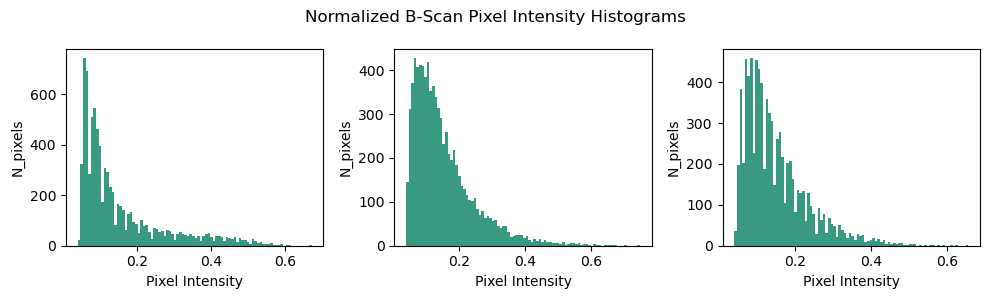

In [81]:
# Plot histograms for normalized bscans 
fig,ax=plt.subplots(1,3,figsize=(10,3))
fig.suptitle('Normalized B-Scan Pixel Intensity Histograms')
for i in range(3):
    fp = cdf[cdf.set==2].normalized_array.values[i+10]
    pixIhist(fp,ax=ax.flat[i],color='#399981',fixed_xrange=False)

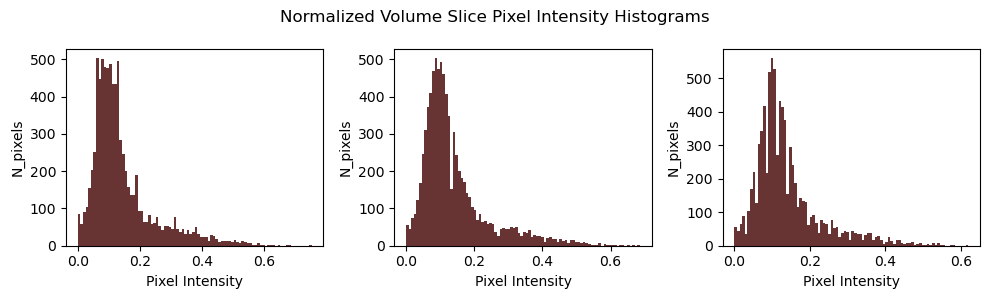

In [82]:
# Compare with normalized volumes
fig,ax=plt.subplots(1,3,figsize=(10,3))
fig.suptitle('Normalized Volume Slice Pixel Intensity Histograms')
for i in range(3):
    fp = cdf[cdf.set==1].normalized_array.values[i+123]
    pixIhist(fp,ax=ax.flat[i],color='#683333',fixed_xrange=False)

Will apply the same normalization procedure to the original volumes alone, to compare model performance when trained on the combined `cdf` set of 2D slices.  As stated during Data Wrangling & EDA, it may be the case that the project will end up focusing on different architectures using the original volume dataset instead of a new combined dataset altogether.

In [83]:
normalized_volpaths = []
for i,normalized_array in enumerate(vMeta.filepath.apply(vizInputParser).apply(lambda x : x / 255)):

    p,g,l = cdf[["PIN","glaucoma","left_eye"]].iloc[i].values
    fn = f"p{p}_{"Glaucoma" if g else "Normal"}_{'OS' if l else 'OD'}_normalized.npy"
    oDIR = '../datasrc/volumesOCT/normalized/'
    if not os.path.isdir(oDIR):
        os.makedirs(oDIR)
    oPATH = os.path.join(oDIR,fn)

    try:
        np.save(oPATH,normalized_array)
        normalized_volpaths.append(oPATH)
    except:
        print(f"Unable to save array #{i} to {oPATH}")

len(normalized_volpaths)

1110

In [84]:
vMeta.rename(columns={'filepath':'display_volume'},inplace=True)
vMeta.insert(loc = vMeta.columns.get_loc('display_volume'),
           column = 'normalized_array',
           value = normalized_volpaths)
vMeta.head()

dx_class  glaucoma patient_id  PIN laterality  left_eye image_type  set  \
826    normal         0     000002  001         OD         0     volume    1   
813    normal         0     000002  001         OS         1     volume    1   
53   glaucoma         1     000008  002         OD         0     volume    1   
426  glaucoma         1     000014  003         OD         0     volume    1   
747  glaucoma         1     000014  003         OS         1     volume    1   

                                      normalized_array  \
826  ../datasrc/volumesOCT/normalized/p001_Normal_O...   
813  ../datasrc/volumesOCT/normalized/p001_Normal_O...   
53   ../datasrc/volumesOCT/normalized/p002_Glaucoma...   
426  ../datasrc/volumesOCT/normalized/p003_Glaucoma...   
747  ../datasrc/volumesOCT/normalized/p003_Glaucoma...   

                                        display_volume  
826  ../datasrc/volumesOCT/Normal-000002-2009-10-28...  
813  ../datasrc/volumesOCT/Normal-000002-2009-10-28...  
53   ../datasrc/volumesOCT/POAG-000008-2009-02-03-O...  
426  ../datasrc/volumesOCT/POAG-000014-2009-11-30-O...  
747  ../datasrc/volumesOCT/POAG-000014-2009-11-30-O...

In [85]:
# Drop any now-irrelevant columns as was done with `cdf`
voldf = vMeta.drop(["image_type","patient_id"],axis=1)
voldf.head()

dx_class  glaucoma  PIN laterality  left_eye  set  \
826    normal         0  001         OD         0    1   
813    normal         0  001         OS         1    1   
53   glaucoma         1  002         OD         0    1   
426  glaucoma         1  003         OD         0    1   
747  glaucoma         1  003         OS         1    1   

                                      normalized_array  \
826  ../datasrc/volumesOCT/normalized/p001_Normal_O...   
813  ../datasrc/volumesOCT/normalized/p001_Normal_O...   
53   ../datasrc/volumesOCT/normalized/p002_Glaucoma...   
426  ../datasrc/volumesOCT/normalized/p003_Glaucoma...   
747  ../datasrc/volumesOCT/normalized/p003_Glaucoma...   

                                        display_volume  
826  ../datasrc/volumesOCT/Normal-000002-2009-10-28...  
813  ../datasrc/volumesOCT/Normal-000002-2009-10-28...  
53   ../datasrc/volumesOCT/POAG-000008-2009-02-03-O...  
426  ../datasrc/volumesOCT/POAG-000014-2009-11-30-O...  
747  ../datasrc/volumesOCT/POAG-000014-2009-11-30-O...

### Train/Test Split 

As stated in previous parts of this project, modeling with the combined dataset will be attempted with a 2D CNN, but will ultimately need to be compared with individual sets, particularly just the 3D Volumes and perhaps just their 2D slices to further assess viability of joining such datasets in the first place.  As such we will perform train-test splits for both the composite set `cdf` and just the volumes alone `voldf`, from which 2D slices can be easily extracted or if axis=0, slice_depth=0.5, then simply subset `cdf` based on the `set` column.

In [86]:
vy=voldf.glaucoma.values
vX=voldf.drop('glaucoma',axis=1).values

vtrain, vtest = train_test_split(voldf, test_size=0.2, random_state=42)
voldf.shape, vtrain.shape, vtest.shape

((1110, 8), (888, 8), (222, 8))

In [87]:
y=cdf.glaucoma.values
X=cdf.drop('glaucoma',axis=1).values

ctrain, ctest = train_test_split(cdf, test_size=0.2, random_state=42)
cdf.shape, ctrain.shape, ctest.shape

((1158, 8), (926, 8), (232, 8))

#### Saving DataFrames for Modeling

In [88]:
cdf.to_csv('../p5_Modeling/combined_slices.csv')
ctrain.to_csv('../p5_Modeling/combined_slices_train.csv')
ctest.to_csv('../p5_Modeling/combined_slices_TEST.csv')

voldf.to_csv('../p5_Modeling/volumes.csv')
vtrain.to_csv('../p5_Modeling/volumes_train.csv')
vtest.to_csv('../p5_Modeling/volumes_TEST.csv')

## Summary 

In this notebook, we:

+ Performed one-hot encoding (binary `object` --> binary `numeric`) of:
      + Target: `dx_class` (glaucoma or normal) --> `glaucoma` (1 or 0)
      + L vs. R eye: `laterality` (OS or OD) --> `left_eye` (1 or 0)
+ Created proxy patient identification numbering for combined set:
    + `patient_id` (object) --> `PIN` (object)
+ Processed 2D B-scans to match volume slices, including:
    + Cropping images down to the optic cup region
        + using masks images where available
        + for those without masks, used shaded regions for cropping
        + dropped scans with neither masks nor shaded region (31 images, with 48 of the original 79 bscan images leftover)
    + Downsampling images to 64x128px
    + Unshaded any shaded images using average color channel differences
    + Converted images to grayscale
+ Extracted slices of volumes to match the processed B-scans
+ Combined 2D images (processed B-scans and volume slices) into single set
+ Normalized pixel intensities of all images in both the composite 2D image set (`cdf`) and the original volume set (`voldf`).
+ Performed train-test split on both sets, keeping the target feature with the others for now.
+ Saved train and test sets to csv files as seen in previous code cell.
